<div class="alert alert-block alert-success">

## PROJECT PROPOSAL: CSCI 4146 and CSCI 6409
    
### Team:
#### 1. Imaad Amyn Rajan
#### 2. Smriti Jha
#### 3. Aswini Anand
#### 4. Sumadhur Vaidyula
#### 5. Arunkumar Subash Gauda

### DOMAIN: Banking and financial Industry.
    
### PROBLEM STATEMENT:

In Banking and financial Industry, asset portfolio majorly determines the revenue and profit of the institution. Hence there is a need to lend good quality assets and often, management is under great pressure for the same.

Our bank, ABC Bank, is also facing losses due to lending of loans that default, badly affecting the image of the bank. We intend to create a solution that can predict the probability of a loan going default based on historical data so that Bank can decide on whether to lend to a customer or not based on the results. This will in turn increase profitability and improve reputation of ABC Bank in the industry.

The dataset we propose to use is Berka dataset for financial institution. The problem looks into how many loans have turned bad (where customer couldn’t repay) from already available data and predicts whether a loan will turn bad or not for new customers. If it will turn bad, ABC bank may choose not to lend him/her. This is a binary classification problem that classifies a loan as good (quality asset) or bad(default).

The database we propose to use was prepared by Petr Berka and Marta Sochorova.The Berka dataset or PKDD’99 Financial Dataset is a collection of anonymized financial information from a Czech bank. The dataset has over 5,300 bank clients with approximately 1,000,000 transactions. Additionally, the bank represented in the dataset has extended around 700 loans and issued nearly 900 credit cards, all of which are in the data. There are 8 raw files in the dataset containing 8 tables with information as below:

#### • Account (account.asc)
#### • Client (client.asc)
#### • Disposition (disp.asc)
#### • Permanent Order (order.asc)
#### • Transaction (trans.asc)
#### • Loan (loan.asc)
#### • credit card (card.asc)
#### • Demographic data (district.asc)

<img src="tables.png">
    
### DATASET LINK: https://github.com/zhouxu-ds/loan-default-prediction

### INSPIRATION:
#### Kaggle.com
#### Github.com
#### Towardsdatascience.com
#### Data.world

### REFERENCE:
#### https://towardsdatascience.com/loan-default-prediction-for-profit-maximization-45fcd461582b
#### https://towardsdatascience.com/loan-default-prediction-an-end-to-end-ml-project-with-real-bank-data-part-1-1405f7aecb9e#447b
#### https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions
</div>

In [1]:
import math
import warnings
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import datetime as dt

# add graphs into jupiter notebook
%matplotlib inline                             
warnings.filterwarnings('ignore')                                    # for ignoring warnings in notebook

from sklearn                            import model_selection       # For model_selection
from sklearn.model_selection            import train_test_split, KFold, LeaveOneOut, cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn import metrics                                          
# getting methods for confusion matrix, F1 score, Accuracy Score
from sklearn.metrics                    import accuracy_score, f1_score, average_precision_score, recall_score, classification_report,\
                                                precision_recall_curve, roc_curve, auc, confusion_matrix, precision_recall_fscore_support, make_scorer


from sklearn.linear_model               import LogisticRegression, LogisticRegressionCV, SGDClassifier, RidgeClassifier, RidgeClassifierCV, Perceptron, PassiveAggressiveClassifier
from sklearn.naive_bayes                import GaussianNB, MultinomialNB
from sklearn.neighbors                  import KNeighborsClassifier
from sklearn.tree                       import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble                   import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm                        import LinearSVC, SVC
from sklearn.semi_supervised            import LabelPropagation, LabelSpreading
from sklearn.discriminant_analysis      import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process           import GaussianProcessClassifier
from sklearn.neural_network             import MLPClassifier
from xgboost                            import XGBClassifier
from lightgbm                           import LGBMClassifier

# Imputer, Encoder and Scaling Libraries
from sklearn.impute                     import SimpleImputer         # importing the SimpleImputer library  
from sklearn.preprocessing              import LabelEncoder          # importing the Encoding library
from sklearn.preprocessing              import StandardScaler        # importing the Standard Scaler library
from sklearn.preprocessing              import MinMaxScaler          # importing MinMaxScaler for data scalling
from scipy.stats                        import zscore                # importing the zscore library

import imblearn
from imblearn.over_sampling             import RandomOverSampler, SMOTE, SMOTEN
from imblearn.under_sampling            import RandomUnderSampler

<div class="alert alert-block alert-danger">
    <b>1. Data Loading</b>
</div>

In [2]:
account_data = pd.read_csv("data/account.asc", header=0, sep=';', engine='python')
card_data = pd.read_csv("data/card.asc", header=0, sep=';', engine='python')
client_data = pd.read_csv("data/client.asc", header=0, sep=';', engine='python')
disp_data = pd.read_csv("data/disp.asc", header=0, sep=';', engine='python')
district_data = pd.read_csv("data/district.asc", header=0, sep=';', engine='python')
loan_data = pd.read_csv("data/loan.asc", header=0, sep=';', engine='python')
order_data = pd.read_csv("data/order.asc", header=0, sep=';', engine='python')
trans_data = pd.read_csv("data/trans.asc", header=0, sep=';', engine='python')

<div class="alert alert-block alert-danger">
    <b>2. Data Cleaning and Merging</b>
</div>

In [3]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   loan_id     682 non-null    int64  
 1   account_id  682 non-null    int64  
 2   date        682 non-null    int64  
 3   amount      682 non-null    int64  
 4   duration    682 non-null    int64  
 5   payments    682 non-null    float64
 6   status      682 non-null    object 
dtypes: float64(1), int64(5), object(1)
memory usage: 37.4+ KB


In [4]:
def birth_number_to_dob_n_gender(birth_number):
    '''
    Use to convert birth number to date of birth and gender
    
    Parameters
    ----------
    birth_number: string birth_number to be provided.
    '''
    yy = "19"+birth_number[0:2]
    mm = birth_number[2:4]
    dd = birth_number[4:6]
    if(int(mm) > 12):
        mm = str(int(mm) - 50)
        gender = 'F'
    else:
        gender = 'M'
    dob = dt.datetime.strptime(yy+mm+dd, '%Y%m%d').strftime('%Y-%m-%d')
    return dob, gender

In [5]:
# as the data is during 1993 to 1997, adding 19 to date string, otherwise will consider as 2000
account_data['date'] = account_data['date'].apply(lambda x:dt.datetime.strptime("19"+str(x), '%Y%m%d'))
card_data['issued'] = card_data['issued'].apply(lambda x:dt.datetime.strptime("19"+str(x), '%Y%m%d %H:%M:%S'))
loan_data['date'] = loan_data['date'].apply(lambda x:dt.datetime.strptime("19"+str(x), '%Y%m%d'))
trans_data['date'] = trans_data['date'].apply(lambda x:dt.datetime.strptime("19"+str(x), '%Y%m%d'))
client_data['date_of_birth'], client_data['gender'] = zip(*client_data['birth_number'].apply(lambda x: birth_number_to_dob_n_gender(str(x))))
order_data.replace('^\s*$', np.nan,regex=True, inplace=True)

In [6]:
def drop_duplicate_records(pd_data):
    '''
    Use to identify and drop duplicate rows of a Pandas dataframe
    
    Parameters
    ----------
    pd_data: Pandas dataframe to be checked for duplicate records and to drop 
    '''
    count,_ = pd_data[pd_data.duplicated(keep=False)].shape
    if count > 0:
        print(f"[INFO] \033[1m{count} number of duplicate record found!\033[0m \n")
        pd_data.drop_duplicates(keep='first',inplace=True)
        print(f"[INFO] \033[1mDuplicate records dropped from {[name for name in globals() if globals()[name] is pd_data]}!\033[0m \n")
    else:
        print(f"[INFO] \033[1mNo duplicate record found from {[name for name in globals() if globals()[name] is pd_data]}!\033[0m \n")

In [7]:
drop_duplicate_records(account_data)
drop_duplicate_records(loan_data)
drop_duplicate_records(order_data)
drop_duplicate_records(trans_data)
drop_duplicate_records(card_data)
drop_duplicate_records(disp_data)
drop_duplicate_records(client_data)
drop_duplicate_records(district_data)

[INFO] No duplicate record found from ['account_data']! 

[INFO] No duplicate record found from ['loan_data']! 

[INFO] No duplicate record found from ['order_data']! 

[INFO] No duplicate record found from ['trans_data']! 

[INFO] No duplicate record found from ['card_data']! 

[INFO] No duplicate record found from ['disp_data']! 

[INFO] No duplicate record found from ['client_data']! 

[INFO] No duplicate record found from ['district_data']! 



In [8]:
#Checking unique values in each column/feature
def column_unique_values(pd_data):
    '''
    Use to find out unique values available in each column of the dataset
    
    Parameters
    ----------
    pd_data : Pandas dataframe to be checked on for unique values
    
    Returns
    ----------
    Unique values avilable on each column in the pandas dataframe passed
    '''
    df = pd.DataFrame(columns = ['Column Name', 'Number of Rows', 'Number of Unique Values', 'Unique Values'])
    for col in pd_data.columns:
        df = df.append({'Column Name' : col, 'Number of Rows': account_data.shape[0], 'Number of Unique Values':pd_data[col].nunique(), 'Unique Values':pd_data[col].unique()}, ignore_index=True)
    return df

In [9]:
# setting column width to zero to get maximum column width
pd.set_option("display.max_colwidth",None)

# calling user defined function to find out unique values available on the dataset except 'descripton' column
unique_col_values = column_unique_values(account_data)
unique_col_values

,Column Name,Number of Rows,Number of Unique Values,Unique Values
0,account_id,4500,4500,"[576, 3818, 704, 2378, 2632, 1972, 1539, 793, 2484, 1695, 1726, 2881, 2357, 2177, 485, 652, 9635, 1844, 1926, 2393, 3510, 1276, 1637, 3871, 192, 764, 2087, 2122, 3592, 3487, 435, 1730, 1493, 374, 2925, 866, 1628, 2379, 1979, 346, 1338, 1909, 2099, 3760, 5270, 1699, 3909, 2926, 1731, 11265, 2519, 10364, 1481, 401, 4034, 2330, 1806, 3834, 1222, 212, 456, 459, 772, 1019, 11295, 2970, 2676, 1536, 1179, 280, 2425, 9307, 4055, 5065, 3704, 477, 5891, 1000, 1750, 2023, 6473, 1649, 2670, 1127, 163, 2566, 9, 1144, 2902, 4296, 443, 3693, 2070, 1843, 2714, 4078, 1675, 5868, 1805, 2434, ...]"
1,district_id,4500,77,"[55, 74, 16, 24, 77, 1, 47, 76, 48, 70, 19, 62, 6, 21, 44, 37, 10, 41, 36, 26, 7, 68, 54, 38, 9, 60, 14, 3, 53, 50, 33, 15, 4, 32, 40, 66, 27, 49, 45, 52, 73, 25, 23, 75, 12, 46, 13, 30, 59, 63, 64, 61, 72, 17, 67, 57, 51, 31, 71, 2, 39, 69, 28, 43, 20, 42, 56, 34, 65, 11, 5, 29, 58, 18, 8, 35, 22]"
2,frequency,4500,3,"[POPLATEK MESICNE, POPLATEK PO OBRATU, POPLATEK TYDNE]"
3,date,4500,1535,"[1993-01-01T00:00:00.000000000, 1993-01-02T00:00:00.000000000, 1993-01-03T00:00:00.000000000, 1993-01-04T00:00:00.000000000, 1993-01-05T00:00:00.000000000, 1993-01-06T00:00:00.000000000, 1993-01-07T00:00:00.000000000, 1993-01-08T00:00:00.000000000, 1993-01-09T00:00:00.000000000, 1993-01-10T00:00:00.000000000, 1993-01-11T00:00:00.000000000, 1993-01-12T00:00:00.000000000, 1993-01-13T00:00:00.000000000, 1993-01-14T00:00:00.000000000, 1993-01-15T00:00:00.000000000, 1993-01-17T00:00:00.000000000, 1993-01-18T00:00:00.000000000, 1993-01-19T00:00:00.000000000, 1993-01-20T00:00:00.000000000, 1993-01-21T00:00:00.000000000, 1993-01-22T00:00:00.000000000, 1993-01-23T00:00:00.000000000, 1993-01-24T00:00:00.000000000, 1993-01-25T00:00:00.000000000, 1993-01-26T00:00:00.000000000, 1993-01-27T00:00:00.000000000, 1993-01-28T00:00:00.000000000, 1993-01-29T00:00:00.000000000, 1993-01-30T00:00:00.000000000, 1993-02-01T00:00:00.000000000, 1993-02-02T00:00:00.000000000, 1993-02-03T00:00:00.000000000, 1993-02-04T00:00:00.000000000, 1993-02-05T00:00:00.000000000, 1993-02-06T00:00:00.000000000, 1993-02-07T00:00:00.000000000, 1993-02-08T00:00:00.000000000, 1993-02-09T00:00:00.000000000, 1993-02-10T00:00:00.000000000, 1993-02-11T00:00:00.000000000, 1993-02-12T00:00:00.000000000, 1993-02-13T00:00:00.000000000, 1993-02-14T00:00:00.000000000, 1993-02-15T00:00:00.000000000, 1993-02-16T00:00:00.000000000, 1993-02-17T00:00:00.000000000, 1993-02-18T00:00:00.000000000, 1993-02-19T00:00:00.000000000, 1993-02-20T00:00:00.000000000, 1993-02-21T00:00:00.000000000, 1993-02-22T00:00:00.000000000, 1993-02-23T00:00:00.000000000, 1993-02-24T00:00:00.000000000, 1993-02-25T00:00:00.000000000, 1993-02-26T00:00:00.000000000, 1993-02-27T00:00:00.000000000, 1993-03-01T00:00:00.000000000, 1993-03-02T00:00:00.000000000, 1993-03-03T00:00:00.000000000, 1993-03-04T00:00:00.000000000, 1993-03-05T00:00:00.000000000, 1993-03-06T00:00:00.000000000, 1993-03-07T00:00:00.000000000, 1993-03-08T00:00:00.000000000, 1993-03-09T00:00:00.000000000, 1993-03-10T00:00:00.000000000, 1993-03-11T00:00:00.000000000, 1993-03-12T00:00:00.000000000, 1993-03-13T00:00:00.000000000, 1993-03-14T00:00:00.000000000, 1993-03-15T00:00:00.000000000, 1993-03-16T00:00:00.000000000, 1993-03-18T00:00:00.000000000, 1993-03-19T00:00:00.000000000, 1993-03-20T00:00:00.000000000, 1993-03-21T00:00:00.000000000, 1993-03-22T00:00:00.000000000, 1993-03-24T00:00:00.000000000, 1993-03-25T00:00:00.000000000, 1993-03-26T00:00:00.000000000, 1993-03-27T00:00:00.000000000, 1993-03-28T00:00:00.000000000, 1993-03-29T00:00:00.000000000, 1993-03-30T00:00:00.000000000, 1993-04-01T00:00:00.000000000, 1993-04-02T00:00:00.000000000, 1993-04-03T00:00:00.000000000, 1993-04-04T00:00:00.000000000, 1993-04-05T00:00:00.000000000, 1993-04-06T00:00:00.000000000, 1993-04-07T00:00:00.000000000, 1993-04-08T00:00:00.000000000, 1993-04-09T00:00:00.000000000, 1993-04-10T00:00:00.0

In [10]:
unique_col_values = column_unique_values(loan_data)
unique_col_values

,Column Name,Number of Rows,Number of Unique Values,Unique Values
0,loan_id,4500,682,"[5314, 5316, 6863, 5325, 7240, 6687, 7284, 6111, 7235, 5997, 7121, 6077, 6228, 6356, 5523, 6456, 7104, 6820, 6876, 7097, 4959, 6499, 5479, 5170, 6721, 7259, 5285, 5189, 6650, 7226, 6087, 7262, 5519, 6577, 6509, 6520, 6699, 6336, 7055, 6103, 6202, 7066, 6696, 6072, 5130, 5568, 6678, 6998, 6580, 6316, 6512, 6407, 5002, 6647, 7137, 6903, 5918, 6642, 6210, 6279, 7249, 6736, 6112, 5319, 6596, 5837, 5657, 5533, 6232, 6888, 6066, 5549, 5060, 6004, 5126, 7220, 6668, 5395, 6836, 6064, 6919, 6841, 6038, 6729, 7198, 6686, 5836, 7061, 5595, 5723, 6120, 6895, 5882, 5754, 6594, 6738, 6624, 6216, 6229, 5887, ...]"
1,account_id,4500,682,"[1787, 1801, 9188, 1843, 11013, 8261, 11265, 5428, 10973, 4894, 10364, 5270, 6034, 6701, 2705, 7123, 10320, 9034, 9236, 10266, 2, 7401, 2486, 1071, 8475, 11111, 1603, 1166, 8073, 10940, 5313, 11135, 2694, 7753, 7445, 7485, 8330, 6555, 10079, 5385, 5891, 10131, 8321, 5256, 813, 2933, 8173, 9833, 7769, 6473, 7454, 6930, 173, 8051, 10439, 9337, 4576, 8027, 5927, 6273, 11065, 8558, 5442, 1811, 7844, 4260, 3354, 2762, 6051, 9265, 5228, 2824, 426, 4937, 790, 10911, 8129, 2176, 9093, 5215, 9403, 9104, 5120, 8519, 10788, 8260, 4259, 10105, 3050, 3674, 5481, 9307, 4427, 3834, 7824, 8566, 7965, 5952, 6040, 4448, ...]"
2,date,4500,559,"[1993-07-05T00:00:00.000000000, 1993-07-11T00:00:00.000000000, 1993-07-28T00:00:00.000000000, 1993-08-03T00:00:00.000000000, 1993-09-06T00:00:00.000000000, 1993-09-13T00:00:00.000000000, 1993-09-15T00:00:00.000000000, 1993-09-24T00:00:00.000000000, 1993-10-13T00:00:00.000000000, 1993-11-04T00:00:00.000000000, 1993-11-10T00:00:00.000000000, 1993-11-22T00:00:00.000000000, 1993-12-01T00:00:00.000000000, 1993-12-08T00:00:00.000000000, 1993-12-09T00:00:00.000000000, 1993-12-13T00:00:00.000000000, 1993-12-16T00:00:00.000000000, 1993-12-21T00:00:00.000000000, 1993-12-23T00:00:00.000000000, 1994-01-05T00:00:00.000000000, 1994-01-10T00:00:00.000000000, 1994-01-20T00:00:00.000000000, 1994-01-21T00:00:00.000000000, 1994-01-31T00:00:00.000000000, 1994-02-06T00:00:00.000000000, 1994-02-07T00:00:00.000000000, 1994-02-17T00:00:00.000000000, 1994-02-23T00:00:00.000000000, 1994-02-27T00:00:00.000000000, 1994-03-01T00:00:00.000000000, 1994-03-08T00:00:00.000000000, 1994-03-11T00:00:00.000000000, 1994-03-15T00:00:00.000000000, 1994-03-16T00:00:00.000000000, 1994-03-30T00:00:00.000000000, 1994-03-31T00:00:00.000000000, 1994-04-06T00:00:00.000000000, 1994-04-07T00:00:00.000000000, 1994-04-18T00:00:00.000000000, 1994-05-02T00:00:00.000000000, 1994-05-09T00:00:00.000000000, 1994-05-10T00:00:00.000000000, 1994-05-11T00:00:00.000000000, 1994-05-17T00:00:00.000000000, 1994-05-20T00:00:00.000000000, 1994-05-21T00:00:00.000000000, 1994-05-22T00:00:00.000000000, 1994-05-26T00:00:00.000000000, 1994-05-31T00:00:00.000000000, 1994-06-01T00:00:00.000000000, 1994-06-03T00:00:00.000000000, 1994-06-04T00:00:00.000000000, 1994-06-05T00:00:00.000000000, 1994-06-06T00:00:00.000000000, 1994-06-07T00:00:00.000000000, 1994-06-12T00:00:00.000000000, 1994-06-14T00:00:00.000000000, 1994-06-17T00:00:00.000000000, 1994-06-23T00:00:00.000000000, 1994-06-25T00:00:00.000000000, 1994-06-29T00:00:00.000000000, 1994-07-05T00:00:00.000000000, 1994-07-08T00:00:00.000000000, 1994-07-11T00:00:00.000000000, 1994-07-16T00:00:00.000000000, 1994-07-19T00:00:00.000000000, 1994-07-23T00:00:00.000000000, 1994-07-24T00:00:00.000000000, 1994-07-28T00:00:00.000000000, 1994-07-30T00:00:00.000000000, 1994-08-03T00:00:00.000000000, 1994-08-04T00:00:00.000000000, 1994-08-05T00:00:00.000000000, 1994-08-07T00:00:00.000000000, 1994-08-10T00:00:00.000000000, 1994-08-11T00:00:00.000000000, 1994-08-23T00:00:00.000000000, 1994-08-25T00:00:00.000000000, 1994-08-27T00:00:00.000000000, 1994-09-02T00:00:00.000000000, 1994-09-10T00:00:00.000000000, 1994-09-11T00:00:00.000000000, 1994-09-19T00:00:00.000000000, 1994-09-26T00:00:00.000000000, 1994-09-28T00:00:00.000000000, 1994-09-29T00:0

In [11]:
unique_col_values = column_unique_values(order_data)
unique_col_values

,Column Name,Number of Rows,Number of Unique Values,Unique Values
0,order_id,4500,6471,"[29401, 29402, 29403, 29404, 29405, 29406, 29407, 29408, 29409, 29410, 29411, 29412, 29413, 29414, 29415, 29416, 29417, 29418, 29419, 29420, 29421, 29422, 29423, 29425, 29426, 29427, 29428, 29429, 29430, 29431, 29432, 29433, 29434, 29435, 29436, 29439, 29440, 29441, 29442, 29443, 29444, 29445, 29446, 29447, 29448, 29449, 29450, 29451, 29452, 29453, 29454, 29455, 29456, 29457, 29458, 29459, 29460, 29461, 29462, 29463, 29464, 29465, 29466, 29467, 29470, 29471, 29472, 29473, 29474, 29475, 29476, 29477, 29478, 29479, 29480, 29481, 29482, 29483, 29484, 29485, 29486, 29487, 29489, 29490, 29493, 29494, 29495, 29496, 29497, 29498, 29499, 29500, 29501, 29502, 29503, 29504, 29505, 29506, 29507, 29508, ...]"
1,account_id,4500,3758,"[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 61, 62, 63, 65, 66, 67, 68, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 88, 90, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 123, 124, ...]"
2,bank_to,4500,13,"[YZ, ST, QR, WX, CD, AB, UV, GH, IJ, KL, EF, MN, OP]"
3,account_to,4500,6446,"[87144583, 89597016, 13943797, 83084338, 24485939, 59972357, 26693541, 5848086, 37390208, 44486999, 34452903, 12510681, 93210345, 18686104, 93182509, 38470870, 23010808, 63607060, 35443323, 11793136, 24265569, 15076423, 14132368, 3399968, 60152441, 34691494, 20774019, 50810194, 46086388, 1301700, 4896235, 79838293, 52864879, 12891853, 28175699, 32924878, 93088209, 41335338, 66168540, 42430687, 33047658, 21845197, 19993174, 58999049, 56788617, 99848401, 80693810, 71644407, 29728555, 23782724, 89609831, 79067885, 2692229, 83435654, 64685678, 77015351, 949460, 31161588, 96111678, 1007766, 55873340, 38318204, 89718746, 11344862, 76620852, 37438374, 83359431, 30289006, 50218236, 2071685, 83233099, 75148117, 17270559, 71050131, 74449389, 6008005, 85721850, 81024360, 90659772, 53077900, 73539948, 55066728, 38201576, 65394794, 20533621, 20426410, 80010622, 85474604, 8346772, 74934333, 20976132, 7764506, 17993182, 45128363, 57342255, 59079301, 86834001, 8292192, 34692824, 92248808, ...]"
4,amount,4500,4412,"[2452.0, 3372.7, 7266.0, 1135.0, 327.0, 3539.0, 2078.0, 1285.0, 2668.0, 3954.0, 4880.0, 2612.0, 6712.0, 7033.0, 1344.0, 2132.0, 297.0, 3295.0, 2444.0, 3629.0, 3072.0, 4032.0, 2523.2, 2003.0, 6276.0, 6352.0, 5807.0, 221.0, 7641.0, 6817.0, 1110.0, 164.0, 10387.0, 4054.0, 6871.0, 829.0, 8.0, 2480.2, 10202.0, 3892.0, 1479.0, 502.0, 6070.0, 1022.0, 1362.0, 4069.0, 5307.5, 2317.0, 2584.0, 97.0, 2306.8, 6901.0, 231.0, 228.0, 145.0, 2970.0, 33.0, 4301.0, 4239.0, 239.0, 1592.0, 6589.0, 2344.0, 6940.0, 174.0, 141.0, 9.0, 6268.0, 1029.0, 3102.0, 269.0, 7024.0, 2074.0, 2057.0, 560.0, 3723.0, 2851.0, 2280.0, 3086.0, 8080.0, 4107.0, 695.0, 6190.0, 1645.0, 668.0, 2273.0, 2237.0, 157.0, 686.0, 3315.0, 3401.0, 4471.3, 6915.0, 6393.0, 445.0, 1705.0, 1186.0, 137.0, 61.0, 4150.0, ...]"
5,k_symbol,4500,4,"[SIPO, UVER, nan, POJISTNE, LEASING]"


In [12]:
unique_col_values = column_unique_values(trans_data)
unique_col_values

,Column Name,Number of Rows,Number of Unique Values,Unique Values
0,trans_id,4500,1056320,"[695247, 171812, 207264, 1117247, 579373, 771035, 452728, 725751, 497211, 232960, 505240, 144541, 637741, 689827, 846006, 637742, 2908688, 232961, 192096, 542215, 565654, 542216, 1027725, 374589, 579374, 699220, 129502, 374590, 57433, 497212, 621760, 480214, 612392, 224342, 1049881, 1132662, 1021120, 439035, 110534, 771036, 506450, 192097, 1117248, 695720, 857973, 477638, 1049882, 252644, 393505, 171813, 581699, 252645, 101386, 689828, 725752, 565655, 857974, 560898, 207265, 477639, 615542, 439036, 1100759, 480215, 1548749, 505241, 846007, 1021121, 2908689, 858384, 498389, 699221, 1142758, 1548750, 506836, 3393738, 621775, 737258, 144549, 435762, 1027726, 3122924, 1176385, 119435, 1100767, 682546, 529772, 1121963, 359511, 63712, 298978, 136957, 135814, 226654, 3402664, 695250, 451890, 785190, 615548, 871631, ...]"
1,account_id,4500,4500,"[2378, 576, 704, 3818, 1972, 2632, 1539, 2484, 1695, 793, 1726, 485, 2177, 2357, 2881, 9635, 652, 1844, 1926, 3510, 1276, 2393, 435, 192, 2122, 1637, 2087, 764, 3592, 3871, 3487, 1493, 374, 1730, 2379, 2925, 1628, 866, 1338, 1979, 346, 1909, 2099, 3760, 5270, 2926, 1699, 3909, 1731, 11265, 2519, 1481, 10364, 4034, 401, 2330, 1806, 3834, 1222, 212, 1019, 459, 456, 772, 11295, 1536, 2676, 2970, 1179, 2425, 280, 4055, 3704, 9307, 5065, 5891, 477, 1000, 1750, 2023, 1649, 6473, 163, 2670, 2566, 1127, 9, 1144, 443, 4296, 2902, 3693, 2070, 4078, 1843, 2714, 1675, 5868, 2574, 1805, ...]"
2,date,4500,2191,"[1993-01-01T00:00:00.000000000, 1993-01-02T00:00:00.000000000, 1993-01-03T00:00:00.000000000, 1993-01-04T00:00:00.000000000, 1993-01-05T00:00:00.000000000, 1993-01-06T00:00:00.000000000, 1993-01-07T00:00:00.000000000, 1993-01-08T00:00:00.000000000, 1993-01-09T00:00:00.000000000, 1993-01-10T00:00:00.000000000, 1993-01-11T00:00:00.000000000, 1993-01-12T00:00:00.000000000, 1993-01-13T00:00:00.000000000, 1993-01-14T00:00:00.000000000, 1993-01-15T00:00:00.000000000, 1993-01-16T00:00:00.000000000, 1993-01-17T00:00:00.000000000, 1993-01-18T00:00:00.000000000, 1993-01-19T00:00:00.000000000, 1993-01-20T00:00:00.000000000, 1993-01-21T00:00:00.000000000, 1993-01-22T00:00:00.000000000, 1993-01-23T00:00:00.000000000, 1993-01-24T00:00:00.000000000, 1993-01-25T00:00:00.000000000, 1993-01-26T00:00:00.000000000, 1993-01-27T00:00:00.000000000, 1993-01-28T00:00:00.000000000, 1993-01-29T00:00:00.000000000, 1993-01-30T00:00:00.000000000, 1993-01-31T00:00:00.000000000, 1993-02-01T00:00:00.000000000, 1993-02-02T00:00:00.000000000, 1993-02-03T00:00:00.000000000, 1993-02-04T00:00:00.000000000, 1993-02-05T00:00:00.000000000, 1993-02-06T00:00:00.000000000, 1993-02-07T00:00:00.000000000, 1993-02-08T00:00:00.000000000, 1993-02-09T00:00:00.000000000, 1993-02-10T00:00:00.000000000, 1993-02-11T00:00:00.000000000, 1993-02-12T00:00:00.000000000, 1993-02-13T00:00:00.000000000, 1993-02-14T00:00:00.000000000, 1993-02-15T00:00:00.000000000, 1993-02-16T00:00:00.000000000, 1993-02-17T00:00:00.000000000, 1993-02-18T00:00:00.000000000, 1993-02-19T00:00:00.000000000, 1993-02-20T00:00:00.000000000, 1993-02-21T00:00:00.000000000, 1993-02-22T00:00:00.000000000, 1993-02-23T00:00:00.000000000, 1993-02-24T00:00:00.000000000, 1993-02-25T00:00:00.000000000, 1993-02-26T00:00:00.000000000, 1993-02-27T00:00:00.000000000, 1993-02-28T00:00:00.000000000, 1993-03-01T00:00:00.000000000, 1993-03-02T00:00:00.000000000, 1993-03-03T00:00:00.000000000, 1993-03-04T00:00:00.000000000, 1993-03-05T00:00:00.000000000, 1993-03-06T00:00:00.000000000, 1993-03-07T00:00:00.000000000, 1993-03-08T00:00:00.000000000, 1993-03-09T00:00:00.000000000, 1993-03-10T00:00:00.000000000, 1993-03-11T00:00:00.000000000, 1993-03-12T00:00:00.000000000, 1993-03-13T00:00:00.000000000, 1993-03-14T00:00:00.000000000, 1993-03-15T00:00:00.000000000, 1993-03-16T00:00:00.000000000, 1993-03-17T00:00:00.000000000, 1993-03-18T00:00:00.000000000, 1993-03-19T00:00:00.000000000, 1993-03-20T00:00:00.000000000, 1993

In [13]:
unique_col_values = column_unique_values(card_data)
unique_col_values

,Column Name,Number of Rows,Number of Unique Values,Unique Values
0,card_id,4500,892,"[1005, 104, 747, 70, 577, 377, 721, 437, 188, 13, 732, 181, 384, 309, 478, 563, 369, 376, 483, 174, 658, 763, 778, 1039, 477, 168, 314, 468, 208, 766, 464, 497, 166, 15, 503, 1038, 737, 418, 759, 223, 5, 159, 1223, 662, 779, 1040, 545, 467, 1247, 652, 559, 719, 397, 107, 661, 484, 501, 422, 705, 410, 136, 592, 262, 18, 3, 98, 167, 97, 699, 342, 713, 118, 783, 1103, 504, 261, 296, 113, 92, 1225, 393, 695, 666, 462, 85, 337, 771, 379, 106, 606, 427, 202, 814, 1064, 14, 423, 989, 364, 267, 621, ...]"
1,disp_id,4500,892,"[9285, 588, 4915, 439, 3687, 2429, 4680, 2762, 1146, 87, 4763, 1066, 2475, 1946, 3084, 3589, 2363, 2428, 3115, 1039, 4251, 5138, 5275, 9837, 3082, 1018, 1999, 3023, 1246, 5200, 2984, 3184, 999, 114, 3225, 9787, 4791, 2623, 5117, 1353, 51, 946, 13231, 4293, 5323, 9890, 3458, 3019, 13660, 4211, 3573, 4663, 2513, 593, 4270, 3116, 3197, 2650, 4555, 2569, 778, 3782, 1647, 128, 41, 537, 1011, 531, 4532, 2157, 4627, 652, 5433, 11189, 3230, 1629, 1876, 629, 508, 13268, 2498, 4507, 4328, 2978, 489, 2141, 5233, 2431, 592, 3883, 2688, 1228, 5911, 10328, 112, 2657, 9119, 2329, 1691, 3970, ...]"
2,type,4500,3,"[classic, junior, gold]"
3,issued,4500,607,"[1993-11-07T00:00:00.000000000, 1994-01-19T00:00:00.000000000, 1994-02-05T00:00:00.000000000, 1994-02-08T00:00:00.000000000, 1994-02-15T00:00:00.000000000, 1994-03-03T00:00:00.000000000, 1994-04-05T00:00:00.000000000, 1994-06-01T00:00:00.000000000, 1994-06-19T00:00:00.000000000, 1994-06-29T00:00:00.000000000, 1994-07-21T00:00:00.000000000, 1994-08-19T00:00:00.000000000, 1994-09-15T00:00:00.000000000, 1994-09-19T00:00:00.000000000, 1994-10-09T00:00:00.000000000, 1994-10-21T00:00:00.000000000, 1994-11-08T00:00:00.000000000, 1994-11-10T00:00:00.000000000, 1994-11-24T00:00:00.000000000, 1994-12-04T00:00:00.000000000, 1994-12-25T00:00:00.000000000, 1994-12-30T00:00:00.000000000, 1995-01-02T00:00:00.000000000, 1995-01-07T00:00:00.000000000, 1995-01-16T00:00:00.000000000, 1995-01-24T00:00:00.000000000, 1995-01-27T00:00:00.000000000, 1995-01-30T00:00:00.000000000, 1995-02-08T00:00:00.000000000, 1995-02-11T00:00:00.000000000, 1995-02-21T00:00:00.000000000, 1995-03-03T00:00:00.000000000, 1995-03-05T00:00:00.000000000, 1995-03-08T00:00:00.000000000, 1995-03-30T00:00:00.000000000, 1995-04-13T00:00:00.000000000, 1995-04-14T00:00:00.000000000, 1995-04-18T00:00:00.000000000, 1995-04-24T00:00:00.000000000, 1995-05-01T00:00:00.000000000, 1995-05-02T00:00:00.000000000, 1995-05-09T00:00:00.000000000, 1995-05-21T00:00:00.000000000, 1995-05-28T00:00:00.000000000, 1995-05-30T00:00:00.000000000, 1995-06-05T00:00:00.000000000, 1995-06-13T00:00:00.000000000, 1995-06-16T00:00:00.000000000, 1995-06-17T00:00:00.000000000, 1995-06-24T00:00:00.000000000, 1995-06-27T00:00:00.000000000, 1995-07-03T00:00:00.000000000, 1995-07-04T00:00:00.000000000, 1995-07-09T00:00:00.000000000, 1995-07-11T00:00:00.000000000, 1995-07-12T00:00:00.000000000, 1995-07-20T00:00:00.000000000, 1995-07-28T00:00:00.000000000, 1995-08-07T00:00:00.000000000, 1995-08-24T00:00:00.000000000, 1995-08-25T00:00:00.000000000, 1995-09-03T00:00:00.000000000, 1995-09-06T00:00:00.000000000, 1995-09-15T00:00:00.000000000, 1995-09-19T00:00:00.000000000, 1995-09-26T00:00:00.000000000, 1995-09-27T00:00:00.000000000, 1995-09-30T00:00:00.000000000, 1995-10-22T00:00:00.000000000, 1995-10-24T00:00:00.000000000, 1995-11-04T00:00:00.000000000, 1995-11-06T00:00:00.000000000, 1995-11-09T00:00:00.000000000, 1995-11-13T00:00:00.000000000, 1995-11-16T00:00:00.000000000, 1995-11-20T00:00:00.000000000, 1995-11-22T00:00:00.000000000, 1995-12-03T00:00:00.000000000, 1995-12-15T00:00:00.000000000, 1995-12-25T00:00:00.000000000, 1995-12-30T00:00:00.000000000, 1995-12-31T00:00:00.000000000, 1996-01-01T00:00:00.000000000, 1996-01-08T00:00:00.000000000, 1996-01-12T00:00:00.000000000, 1996-01-14T00:00:00.000000000, 1996-01-22T00:00:00.000000000, 1996-01-25T00:00:00.000000000, 1996-02-04T00

In [14]:
unique_col_values = column_unique_values(disp_data)
unique_col_values

,Column Name,Number of Rows,Number of Unique Values,Unique Values
0,disp_id,4500,5369,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, ...]"
1,client_id,4500,5369,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, ...]"
2,account_id,4500,4500,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, ...]"
3,type,4500,2,"[OWNER, DISPONENT]"


In [15]:
unique_col_values = column_unique_values(client_data)
unique_col_values

,Column Name,Number of Rows,Number of Unique Values,Unique Values
0,client_id,4500,5369,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, ...]"
1,birth_number,4500,5019,"[706213, 450204, 406009, 561201, 605703, 190922, 290125, 385221, 351016, 430501, 505822, 810220, 745529, 425622, 185828, 190225, 341013, 315405, 421228, 790104, 526029, 696011, 730529, 395729, 395423, 695420, 665326, 450929, 515911, 576009, 620209, 800728, 486204, 785717, 700810, 735723, 680125, 575122, 680827, 350817, 201028, 775111, 520826, 405130, 340714, 400209, 595511, 785730, 796202, 241212, 770505, 485918, 600331, 616217, 275429, 570218, 800219, 485806, 321208, 590604, 260422, 435527, 516110, 326111, 461214, 251222, 275206, 230113, 240220, 255726, 775919, 676001, 565218, 445613, 695310, 795225, 760429, 796225, 786225, 790505, 610827, 695720, 466117, 515505, 750817, 400807, 665612, 250216, 470909, 525803, 720229, 651128, 735504, 730126, 425811, 430123, 585910, 550711, 800526, 686230, ...]"
2,district_id,4500,77,"[18, 1, 5, 12, 15, 51, 60, 57, 40, 54, 76, 21, 47, 46, 43, 74, 30, 68, 52, 73, 7, 36, 22, 75, 38, 20, 19, 16, 72, 39, 32, 64, 45, 67, 77, 4, 50, 29, 70, 37, 8, 63, 3, 26, 33, 44, 31, 17, 2, 55, 41, 35, 11, 53, 6, 27, 65, 13, 34, 24, 10, 58, 28, 59, 66, 71, 48, 69, 61, 56, 25, 49, 14, 62, 42, 23, 9]"
3,date_of_birth,4500,4714,"[1970-12-13, 1945-02-04, 1940-10-09, 1956-12-01, 1960-07-03, 1919-09-22, 1929-01-25, 1938-02-21, 1935-10-16, 1943-05-01, 1950-08-22, 1981-02-20, 1974-05-29, 1942-06-22, 1918-08-28, 1919-02-25, 1934-10-13, 1931-04-05, 1942-12-28, 1979-01-04, 1952-10-29, 1969-10-11, 1973-05-29, 1939-07-29, 1939-04-23, 1969-04-20, 1966-03-26, 1945-09-29, 1951-09-11, 1957-10-09, 1962-02-09, 1980-07-28, 1948-12-04, 1978-07-17, 1970-08-10, 1973-07-23, 1968-01-25, 1957-12-02, 1968-08-27, 1935-08-17, 1920-10-28, 1977-11-01, 1952-08-26, 1940-01-30, 1934-07-14, 1940-02-09, 1959-05-11, 1978-07-30, 1979-12-02, 1924-12-12, 1977-05-05, 1948-09-18, 1960-03-31, 1961-12-17, 1927-04-29, 1957-02-18, 1980-02-19, 1948-08-06, 1932-12-08, 1959-06-04, 1926-04-22, 1943-05-27, 1951-11-10, 1932-11-11, 1946-12-14, 1925-12-22, 1927-02-06, 1923-01-13, 1924-02-20, 1925-07-26, 1977-09-19, 1967-10-01, 1956-02-18, 1944-06-13, 1969-03-10, 1979-02-25, 1976-04-29, 1979-12-25, 1978-12-25, 1979-05-05, 1961-08-27, 1969-07-20, 1946-11-17, 1951-05-05, 1975-08-17, 1940-08-07, 1966-06-12, 1925-02-16, 1947-09-09, 1952-08-03, 1972-02-29, 1965-11-28, 1973-05-04, 1973-01-26, 1942-08-11, 1943-01-23, 1958-09-10, 1955-07-11, 1980-05-26, 1968-12-30, ...]"
4,gender,4500,2,"[F, M]"


In [16]:
unique_col_values = column_unique_values(district_data)
unique_col_values

,Column Name,Number of Rows,Number of Unique Values,Unique Values
0,A1,4500,77,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]"
1,A2,4500,77,"[Hl.m. Praha, Benesov, Beroun, Kladno, Kolin, Kutna Hora, Melnik, Mlada Boleslav, Nymburk, Praha - vychod, Praha - zapad, Pribram, Rakovnik, Ceske Budejovice, Cesky Krumlov, Jindrichuv Hradec, Pelhrimov, Pisek, Prachatice, Strakonice, Tabor, Domazlice, Cheb, Karlovy Vary, Klatovy, Plzen - mesto, Plzen - jih, Plzen - sever, Rokycany, Sokolov, Tachov, Ceska Lipa, Decin, Chomutov, Jablonec n. Nisou, Liberec, Litomerice, Louny, Most, Teplice, Usti nad Labem, Havlickuv Brod, Hradec Kralove, Chrudim, Jicin, Nachod, Pardubice, Rychnov nad Kneznou, Semily, Svitavy, Trutnov, Usti nad Orlici, Blansko, Brno - mesto, Brno - venkov, Breclav, Hodonin, Jihlava, Kromeriz, Prostejov, Trebic, Uherske Hradiste, Vyskov, Zlin, Znojmo, Zdar nad Sazavou, Bruntal, Frydek - Mistek, Jesenik, Karvina, Novy Jicin, Olomouc, Opava, Ostrava - mesto, Prerov, Sumperk, Vsetin]"
2,A3,4500,8,"[Prague, central Bohemia, south Bohemia, west Bohemia, north Bohemia, east Bohemia, south Moravia, north Moravia]"
3,A4,4500,77,"[1204953, 88884, 75232, 149893, 95616, 77963, 94725, 112065, 81344, 92084, 75637, 107870, 53921, 177686, 58796, 93931, 74062, 70699, 51428, 70646, 103347, 58400, 87419, 122603, 88757, 170449, 67298, 72541, 45714, 94812, 51313, 105058, 133777, 125236, 88768, 159617, 114006, 85852, 119895, 128118, 118650, 95907, 161854, 105606, 77917, 112709, 162580, 78955, 75685, 102609, 121947, 139012, 107911, 387570, 157042, 124605, 161954, 109164, 108871, 110643, 117897, 145688, 86513, 197099, 114200, 125832, 106054, 228848, 42821, 285387, 161227, 226122, 182027, 323870, 138032, 127369, 148545]"
4,A5,4500,53,"[0, 80, 55, 63, 65, 60, 38, 95, 61, 35, 84, 69, 22, 74, 99, 50, 94, 87, 21, 25, 71, 66, 52, 15, 34, 32, 24, 28, 10, 29, 41, 17, 9, 8, 73, 77, 85, 48, 83, 31, 75, 37, 59, 88, 49, 11, 98, 139, 101, 151, 4, 5, 67]"
5,A6,4500,36,"[0, 26, 29, 30, 23, 28, 19, 36, 22, 27, 16, 21, 15, 13, 11, 14, 33, 10, 12, 17, 18, 4, 8, 25, 20, 24, 41, 70, 42, 37, 40, 2, 35, 50, 49, 32]"
6,A7,4500,17,"[0, 6, 4, 1, 7, 9, 10, 2, 3, 5, 8, 18, 14, 20, 13, 11, 12]"
7,A8,4500,6,"[1, 2, 3, 0, 4, 5]"
8,A9,4500,11,"[1, 5, 6, 4, 8, 7, 2, 9, 10, 11, 3]"
9,A10,4500,70,"[100.0, 46.7, 41.7, 67.4, 51.4, 51.5, 63.4, 69.4, 55.3, 36.5, 58.0, 41.3, 74.8, 51.9, 56.9, 61.4, 65.3, 52.7, 58.4, 67.0, 52.4, 85.5, 80.0, 61.7, 43.8, 36.9, 55.6, 81.8, 59.2, 81.0, 84.7, 87.7, 80.5, 85.2, 62.3, 59.8, 89.9, 85.3, 85.6, 59.1, 76.3, 53.0, 53.5, 73.5, 72.8, 59.0, 60.8, 52.0, 70.5, 61.9, 50.9, 33.9, 46.0, 48.0, 63.6, 62.1, 53.8, 40.7, 50.5, 74.7, 43.7, 48.3, 63.1, 57.2, 48.4, 69.7, 62.6, 56.4, 64.6, 51.2]"


In [17]:
# checking statistical summary of the dataframe
account_data.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
account_id,4500.0,NaN,NaN,NaN,NaT,NaT,2786.067556,2313.811984,1.0,1182.75,2368.0,3552.25,11382.0
district_id,4500.0,NaN,NaN,NaN,NaT,NaT,37.310444,25.177217,1.0,13.0,38.0,60.0,77.0
frequency,4500,3,POPLATEK MESICNE,4167,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,4500,1535,1993-02-08 00:00:00,13,1993-01-01,1997-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
loan_data.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
loan_id,682.0,NaN,NaN,NaN,NaT,NaT,6172.466276,682.579279,4959.0,5577.5,6176.5,6752.5,7308.0
account_id,682.0,NaN,NaN,NaN,NaT,NaT,5824.162757,3283.512681,2.0,2967.0,5738.5,8686.0,11362.0
date,682,559,1998-04-19 00:00:00,4,1993-07-05,1998-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,682.0,NaN,NaN,NaN,NaT,NaT,151410.175953,113372.40631,4980.0,66732.0,116928.0,210654.0,590820.0
duration,682.0,NaN,NaN,NaN,NaT,NaT,36.492669,17.075219,12.0,24.0,36.0,48.0,60.0
payments,682.0,NaN,NaN,NaN,NaT,NaT,4190.664223,2215.830344,304.0,2477.0,3934.0,5813.5,9910.0
status,682,4,C,403,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
order_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
order_id,6471.0,NaN,NaN,NaN,33778.197497,3737.681949,29401.0,31187.5,32988.0,34785.5,46338.0
account_id,6471.0,NaN,NaN,NaN,2962.30289,2518.503228,1.0,1223.0,2433.0,3645.5,11362.0
bank_to,6471,13,QR,531,NaN,NaN,NaN,NaN,NaN,NaN,NaN
account_to,6471.0,NaN,NaN,NaN,49399036.851182,28883559.113534,399.0,24159184.0,49756062.0,74000447.5,99994199.0
amount,6471.0,NaN,NaN,NaN,3280.635698,2714.475335,1.0,1241.5,2596.0,4613.5,14882.0
k_symbol,5092,4,SIPO,3502,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
trans_data.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
trans_id,1056320.0,NaN,NaN,NaN,NaT,NaT,1335310.70433,1227486.508382,1.0,430262.75,858506.5,2060979.25,3682987.0
account_id,1056320.0,NaN,NaN,NaN,NaT,NaT,2936.86729,2477.345127,1.0,1204.0,2434.0,3660.0,11382.0
date,1056320,2191,1998-06-30 00:00:00,9269,1993-01-01,1998-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,1056320,3,VYDAJ,634571,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
operation,873206,5,VYBER,434918,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,1056320.0,NaN,NaN,NaN,NaT,NaT,5924.145676,9522.735373,0.0,135.9,2100.0,6800.0,87400.0
balance,1056320.0,NaN,NaN,NaN,NaT,NaT,38518.330803,22117.868013,-41125.7,22402.5,33143.4,49603.625,209637.0
k_symbol,574439,8,UROK,183114,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bank,273508,13,QR,22285,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
account,295389.0,NaN,NaN,NaN,NaT,NaT,45670919.374916,30663396.851208,0.0,17828584.0,45750951.0,72013407.0,99994199.0


In [21]:
card_data.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
card_id,892.0,NaN,NaN,NaN,NaT,NaT,480.855381,306.933982,1.0,229.75,456.5,684.25,1247.0
disp_id,892.0,NaN,NaN,NaN,NaT,NaT,3511.862108,2984.373626,9.0,1387.0,2938.5,4459.5,13660.0
type,892,3,classic,659,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
issued,892,607,1998-09-29 00:00:00,7,1993-11-07,1998-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
disp_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
disp_id,5369.0,NaN,NaN,NaN,3337.09797,2770.418826,1.0,1418.0,2839.0,4257.0,13690.0
client_id,5369.0,NaN,NaN,NaN,3359.01192,2832.911984,1.0,1418.0,2839.0,4257.0,13998.0
account_id,5369.0,NaN,NaN,NaN,2767.496927,2307.84363,1.0,1178.0,2349.0,3526.0,11382.0
type,5369,2,OWNER,4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
client_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
client_id,5369.0,NaN,NaN,NaN,3359.01192,2832.911984,1.0,1418.0,2839.0,4257.0,13998.0
birth_number,5369.0,NaN,NaN,NaN,535114.970013,172895.618429,110820.0,406009.0,540829.0,681013.0,875927.0
district_id,5369.0,NaN,NaN,NaN,37.310114,25.04369,1.0,14.0,38.0,60.0,77.0
date_of_birth,5369,4714,1970-10-07,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,5369,2,M,2724,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
district_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
A1,77.0,NaN,NaN,NaN,39.0,22.371857,1.0,20.0,39.0,58.0,77.0
A2,77,77,Hl.m. Praha,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A3,77,8,south Moravia,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A4,77.0,NaN,NaN,NaN,133884.896104,136913.464909,42821.0,85852.0,108871.0,139012.0,1204953.0
A5,77.0,NaN,NaN,NaN,48.623377,32.741829,0.0,22.0,49.0,71.0,151.0
A6,77.0,NaN,NaN,NaN,24.324675,12.780991,0.0,16.0,25.0,32.0,70.0
A7,77.0,NaN,NaN,NaN,6.272727,4.015222,0.0,4.0,6.0,8.0,20.0
A8,77.0,NaN,NaN,NaN,1.727273,1.008338,0.0,1.0,2.0,2.0,5.0
A9,77.0,NaN,NaN,NaN,6.25974,2.435497,1.0,5.0,6.0,8.0,11.0
A10,77.0,NaN,NaN,NaN,63.035065,16.221727,33.9,51.9,59.8,73.5,100.0


In [25]:
account_data.head()

,account_id,district_id,frequency,date
0,576,55,POPLATEK MESICNE,1993-01-01
1,3818,74,POPLATEK MESICNE,1993-01-01
2,704,55,POPLATEK MESICNE,1993-01-01
3,2378,16,POPLATEK MESICNE,1993-01-01
4,2632,24,POPLATEK MESICNE,1993-01-02


In [26]:
# setting account_id column as index to join with loan dataframe
account_data.set_index('account_id',inplace=True)

In [27]:
account_data.head()

,district_id,frequency,date
account_id,,,
576,55,POPLATEK MESICNE,1993-01-01
3818,74,POPLATEK MESICNE,1993-01-01
704,55,POPLATEK MESICNE,1993-01-01
2378,16,POPLATEK MESICNE,1993-01-01
2632,24,POPLATEK MESICNE,1993-01-02


In [28]:
loan_data.head()

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,1993-07-05,96396,12,8033.0,B
1,5316,1801,1993-07-11,165960,36,4610.0,A
2,6863,9188,1993-07-28,127080,60,2118.0,A
3,5325,1843,1993-08-03,105804,36,2939.0,A
4,7240,11013,1993-09-06,274740,60,4579.0,A


In [29]:
# setting account_id column as index to join with Account dataframe
loan_data.set_index('account_id',inplace=True)

In [30]:
loan_data.head()

,loan_id,date,amount,duration,payments,status
account_id,,,,,,
1787,5314,1993-07-05,96396,12,8033.0,B
1801,5316,1993-07-11,165960,36,4610.0,A
9188,6863,1993-07-28,127080,60,2118.0,A
1843,5325,1993-08-03,105804,36,2939.0,A
11013,7240,1993-09-06,274740,60,4579.0,A


In [31]:
# merging Loan dataframe with Account dataframe and creating main_df dataframe
main_df = loan_data.join(account_data,rsuffix='_account')

In [32]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 1787 to 8645
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   loan_id       682 non-null    int64         
 1   date          682 non-null    datetime64[ns]
 2   amount        682 non-null    int64         
 3   duration      682 non-null    int64         
 4   payments      682 non-null    float64       
 5   status        682 non-null    object        
 6   district_id   682 non-null    int64         
 7   frequency     682 non-null    object        
 8   date_account  682 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(4), object(2)
memory usage: 69.4+ KB


In [33]:
# resetting index for main_df dataframe
main_df.reset_index(inplace=True)

In [34]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   account_id    682 non-null    int64         
 1   loan_id       682 non-null    int64         
 2   date          682 non-null    datetime64[ns]
 3   amount        682 non-null    int64         
 4   duration      682 non-null    int64         
 5   payments      682 non-null    float64       
 6   status        682 non-null    object        
 7   district_id   682 non-null    int64         
 8   frequency     682 non-null    object        
 9   date_account  682 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(5), object(2)
memory usage: 53.4+ KB


In [35]:
# setting district_id column as index to join with district dataframe
main_df.set_index('district_id',inplace=True)

In [36]:
main_df.head()

,account_id,loan_id,date,amount,duration,payments,status,frequency,date_account
district_id,,,,,,,,,
30,1787,5314,1993-07-05,96396,12,8033.0,B,POPLATEK TYDNE,1993-03-22
46,1801,5316,1993-07-11,165960,36,4610.0,A,POPLATEK MESICNE,1993-02-13
45,9188,6863,1993-07-28,127080,60,2118.0,A,POPLATEK MESICNE,1993-02-08
12,1843,5325,1993-08-03,105804,36,2939.0,A,POPLATEK MESICNE,1993-01-30
1,11013,7240,1993-09-06,274740,60,4579.0,A,POPLATEK TYDNE,1993-02-14


In [37]:
district_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      77 non-null     int64  
 1   A2      77 non-null     object 
 2   A3      77 non-null     object 
 3   A4      77 non-null     int64  
 4   A5      77 non-null     int64  
 5   A6      77 non-null     int64  
 6   A7      77 non-null     int64  
 7   A8      77 non-null     int64  
 8   A9      77 non-null     int64  
 9   A10     77 non-null     float64
 10  A11     77 non-null     int64  
 11  A12     77 non-null     object 
 12  A13     77 non-null     float64
 13  A14     77 non-null     int64  
 14  A15     77 non-null     object 
 15  A16     77 non-null     int64  
dtypes: float64(2), int64(10), object(4)
memory usage: 9.8+ KB


In [38]:
district_data = district_data.rename(columns={'A1': 'district_id'})

In [39]:
# merging main_df dataframe with district dataframe and replacing main_df dataframe
main_df = main_df.join(district_data.set_index('district_id'),rsuffix='_district')

In [40]:
main_df.head()

,account_id,loan_id,date,amount,duration,payments,status,frequency,date_account,A2,...,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
district_id,,,,,,,,,,,,,,,,,,,,,
1,11013,7240,1993-09-06,274740,60,4579.0,A,POPLATEK TYDNE,1993-02-14,Hl.m. Praha,...,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,9034,6820,1993-12-16,38148,12,3179.0,A,POPLATEK MESICNE,1993-06-28,Hl.m. Praha,...,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,4959,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,Hl.m. Praha,...,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,7401,6499,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,Hl.m. Praha,...,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2486,5479,1994-01-10,24516,12,2043.0,A,POPLATEK MESICNE,1993-02-27,Hl.m. Praha,...,0,1,1,100.0,12541,0.29,0.43,167,85677,99107


In [41]:
# resetting index of main_df dataframe
main_df.reset_index(inplace=True)
# setting account_id column as index to join with order dataframe
main_df.set_index('account_id', inplace=True)

In [42]:
order_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_id    6471 non-null   int64  
 1   account_id  6471 non-null   int64  
 2   bank_to     6471 non-null   object 
 3   account_to  6471 non-null   int64  
 4   amount      6471 non-null   float64
 5   k_symbol    5092 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 303.5+ KB


In [43]:
# order dataframe contains characteristics of different payment order
# taking average (mean) order amount for a single account_id and then merging with main_df dataframe
main_df = main_df.join(order_data.groupby('account_id').mean()[['amount']], rsuffix='_order')
main_df = main_df.rename(columns={'amount_order': 'average_order_amount'})

In [44]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 11013 to 4268
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   district_id           682 non-null    int64         
 1   loan_id               682 non-null    int64         
 2   date                  682 non-null    datetime64[ns]
 3   amount                682 non-null    int64         
 4   duration              682 non-null    int64         
 5   payments              682 non-null    float64       
 6   status                682 non-null    object        
 7   frequency             682 non-null    object        
 8   date_account          682 non-null    datetime64[ns]
 9   A2                    682 non-null    object        
 10  A3                    682 non-null    object        
 11  A4                    682 non-null    int64         
 12  A5                    682 non-null    int64         
 13  A6             

In [45]:
trans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   trans_id    1056320 non-null  int64         
 1   account_id  1056320 non-null  int64         
 2   date        1056320 non-null  datetime64[ns]
 3   type        1056320 non-null  object        
 4   operation   873206 non-null   object        
 5   amount      1056320 non-null  float64       
 6   balance     1056320 non-null  float64       
 7   k_symbol    574439 non-null   object        
 8   bank        273508 non-null   object        
 9   account     295389 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 80.6+ MB


In [46]:
# creating no_of_transaction happened per account_id on transaction dataframe
no_of_trans = trans_data.groupby('account_id').count().iloc[:, 1]
no_of_trans.name = 'no_of_trans'
# taking average amount and balance per account_id from transaction dataset
trans_data = trans_data.groupby('account_id').mean()[['amount','balance']]
# renaming columns
trans_data.columns = ['average_trans_amount', 'average_trans_balance']
# merginf trans_data and no_of_transaction with main_df dataframe
main_df = main_df.join(trans_data).join(no_of_trans)

In [47]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 11013 to 4268
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   district_id            682 non-null    int64         
 1   loan_id                682 non-null    int64         
 2   date                   682 non-null    datetime64[ns]
 3   amount                 682 non-null    int64         
 4   duration               682 non-null    int64         
 5   payments               682 non-null    float64       
 6   status                 682 non-null    object        
 7   frequency              682 non-null    object        
 8   date_account           682 non-null    datetime64[ns]
 9   A2                     682 non-null    object        
 10  A3                     682 non-null    object        
 11  A4                     682 non-null    int64         
 12  A5                     682 non-null    int64         
 13  

In [48]:
disp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   disp_id     5369 non-null   int64 
 1   client_id   5369 non-null   int64 
 2   account_id  5369 non-null   int64 
 3   type        5369 non-null   object
dtypes: int64(3), object(1)
memory usage: 167.9+ KB


In [49]:
# from disposition dataframe taking only disp_id, client_id and account_id columns and then setting index with account_id for merging with main_df dataframe
main_df = main_df.join(disp_data[disp_data['type']=='OWNER'][['disp_id','client_id','account_id']].set_index('account_id'))

In [50]:
main_df

,district_id,loan_id,date,amount,duration,payments,status,frequency,date_account,A2,...,A13,A14,A15,A16,average_order_amount,average_trans_amount,average_trans_balance,no_of_trans,disp_id,client_id
account_id,,,,,,,,,,,,,,,,,,,,,
11013,1,7240,1993-09-06,274740,60,4579.0,A,POPLATEK TYDNE,1993-02-14,Hl.m. Praha,...,0.43,167,85677,99107,4944.666667,11166.871804,56912.551664,571,13231,13539
9034,1,6820,1993-12-16,38148,12,3179.0,A,POPLATEK MESICNE,1993-06-28,Hl.m. Praha,...,0.43,167,85677,99107,4403.000000,5386.022259,39267.009165,611,10818,11126
2,1,4959,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,Hl.m. Praha,...,0.43,167,85677,99107,5319.350000,6593.052929,36540.704393,478,2,2
7401,1,6499,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,Hl.m. Praha,...,0.43,167,85677,99107,5319.350000,6605.885774,35557.497908,478,8865,9173
2486,1,5479,1994-01-10,24516,12,2043.0,A,POPLATEK MESICNE,1993-02-27,Hl.m. Praha,...,0.43,167,85677,99107,2043.000000,12940.828464,55885.483895,534,3001,3001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5228,77,6066,1994-07-11,173808,24,7242.0,A,POPLATEK PO OBRATU,1993-06-23,Vsetin,...,5.56,113,3460,3590,7242.000000,15677.367401,64091.716520,454,6317,6317
2994,77,5586,1996-09-14,48744,36,1354.0,C,POPLATEK MESICNE,1996-05-03,Vsetin,...,5.56,113,3460,3590,2285.500000,6264.880660,50284.931132,212,3616,3616
4631,77,5933,1997-12-13,87528,24,3647.0,C,POPLATEK PO OBRATU,1996-12-12,Vsetin,...,5.56,113,3460,3590,3647.000000,8315.958647,58287.475940,133,5579,5579


In [51]:
# resetting index of main_df
main_df.reset_index(inplace=True)
# setting disp_id as index of main_df dataframe for merging with card dataframe
main_df.set_index('disp_id',inplace=True)
# merging card dataframe with main_df dataframe
main_df = main_df.join(card_data.set_index('disp_id'))

In [52]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 13231 to 5143
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   account_id             682 non-null    int64         
 1   district_id            682 non-null    int64         
 2   loan_id                682 non-null    int64         
 3   date                   682 non-null    datetime64[ns]
 4   amount                 682 non-null    int64         
 5   duration               682 non-null    int64         
 6   payments               682 non-null    float64       
 7   status                 682 non-null    object        
 8   frequency              682 non-null    object        
 9   date_account           682 non-null    datetime64[ns]
 10  A2                     682 non-null    object        
 11  A3                     682 non-null    object        
 12  A4                     682 non-null    int64         
 13  

In [53]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   client_id      5369 non-null   int64 
 1   birth_number   5369 non-null   int64 
 2   district_id    5369 non-null   int64 
 3   date_of_birth  5369 non-null   object
 4   gender         5369 non-null   object
dtypes: int64(3), object(2)
memory usage: 209.9+ KB


In [54]:
# resetting index
main_df.reset_index(inplace=True)
# setting client_id as index in main_df for merging with client dataframe
main_df.set_index('client_id',inplace=True)
# merging client dataframe with main_df
main_df = main_df.join(client_data[['client_id','date_of_birth','gender']].set_index('client_id'))

In [55]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 13539 to 5143
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   disp_id                682 non-null    int64         
 1   account_id             682 non-null    int64         
 2   district_id            682 non-null    int64         
 3   loan_id                682 non-null    int64         
 4   date                   682 non-null    datetime64[ns]
 5   amount                 682 non-null    int64         
 6   duration               682 non-null    int64         
 7   payments               682 non-null    float64       
 8   status                 682 non-null    object        
 9   frequency              682 non-null    object        
 10  date_account           682 non-null    datetime64[ns]
 11  A2                     682 non-null    object        
 12  A3                     682 non-null    object        
 13  

In [56]:
#resetting index
main_df.reset_index(inplace=True)

In [57]:
main_df

,client_id,disp_id,account_id,district_id,loan_id,date,amount,duration,payments,status,...,A16,average_order_amount,average_trans_amount,average_trans_balance,no_of_trans,card_id,type,issued,date_of_birth,gender
0,13539,13231,11013,1,7240,1993-09-06,274740,60,4579.0,A,...,99107,4944.666667,11166.871804,56912.551664,571,1223.0,junior,1995-05-02,1978-09-07,M
1,11126,10818,9034,1,6820,1993-12-16,38148,12,3179.0,A,...,99107,4403.000000,5386.022259,39267.009165,611,NaN,NaN,NaT,1965-12-02,F
2,2,2,2,1,4959,1994-01-05,80952,24,3373.0,A,...,99107,5319.350000,6593.052929,36540.704393,478,NaN,NaN,NaT,1945-02-04,M
3,9173,8865,7401,1,6499,1994-01-05,80952,24,3373.0,A,...,99107,5319.350000,6605.885774,35557.497908,478,NaN,NaN,NaT,1945-02-04,M
4,3001,3001,2486,1,5479,1994-01-10,24516,12,2043.0,A,...,99107,2043.000000,12940.828464,55885.483895,534,NaN,NaN,NaT,1958-10-07,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,6317,6317,5228,77,6066,1994-07-11,173808,24,7242.0,A,...,3590,7242.000000,15677.367401,64091.716520,454,NaN,NaN,NaT,1957-12-07,F
678,3616,3616,2994,77,5586,1996-09-14,48744,36,1354.0,C,...,3590,2285.500000,6264.880660,50284.931132,212,569.0,classic,1997-12-12,1964-04-14,F
679,5579,5579,4631,77,5933,1997-12-13,87528,24,3647.0,C,...,3590,3647.000000,8315.958647,58287.475940,133,796.0,classic,1998-02-20,1951-02-16,M
680,8667,8667,7181,77,6470,1998-05-17,49872,12,4156.0,C,...,3590,2027.500000,6657.845270,56545.898986,296,NaN,NaN,NaT,1967-02-12,F


In [58]:
# creating function for outlier detection

In [59]:
def showOutliers(pdData):
    '''
    Use to identify outliers, show summary of outliers in each column and plot boxplot for visualization
    
    Parameters
    ----------
    pd_data: Pandas dataframe to be checked for presence of outliers 
    '''
    colNames = []
    meanOut = []
    medianOut = []
    lowerQ = []
    upperQ = []
    iqrOut = []
    noOfOutLiers = []
    perOfOutliers = []
    valOutliers = []
    # looping through all numeric datatype columns
    for feature in (pdData.select_dtypes(include=np.number).columns.tolist()):
        Q1 = pdData[feature].quantile(0.25)        # evaluating lower / first quartile
        Q3 = pdData[feature].quantile(0.75)        # evaluating upper / third quartile
        IQR = Q3 - Q1                             # evaluating Inter Quartile Range i.e IQR
        '''
        finding outliers which are mild outliers (Lower quartile - 1.5 times IQR) or
        extreme outliers (Upper quartile + 1.5 times IQR)
        '''
        outliers = pdData[((pdData[feature] < (Q1 - 1.5 * IQR)) |(pdData[feature] > (Q3 + 1.5 * IQR)))][feature]
        if(outliers.shape[0] != 0):
            
            colNames.append(feature)
            meanOut.append(round(np.mean(pdData[feature]),3))
            medianOut.append(round(np.median(pdData[feature]),3))
            lowerQ.append(Q1)
            upperQ.append(Q3)
            iqrOut.append(round(IQR,3))
            noOfOutLiers.append(outliers.shape[0])
            perOfOutliers.append(str(round(((outliers.shape[0]/pdData[feature].shape[0])*100),3))+" %")
            valOutliers.append(sorted(outliers.tolist()))
            
            plt.figure(figsize=(15,3))                # setting figure size with width = 15 and height = 3
            print("*"*30)
            print("\033[1mBoxplot of {0} column : \033[0m".format(feature))
            print("*"*30)
            ax = sns.boxplot(x=pdData[feature])        # seaborn boxplot to examine outliers of the feature
            plt.pause(0.005)
            # printing mean, median and IQR for the feature
            print("\033[1mFeature {0} : Mean = {1}, Median = {2} and Inter-Quartile-Range (IQR) = {3}\033[0m"
                  .format(feature,round(np.mean(pdData[feature]),3),round(np.median(pdData[feature]),3),round(IQR,3))
                 )
            # printing No of outliers, percentage of the data points that are outliers and the values of the outliers
            print("There are \033[1m{0} outliers\033[0m ({1} % of the data points) in \033[1m{2}\033[0m feature and the values are \033[1m{3}\033[0m"
            .format(outliers.shape[0],round(((outliers.shape[0]/pdData[feature].shape[0])*100),3),feature,outliers.tolist()))
            print("*"*125)
        else:
            colNames.append(feature)
            meanOut.append(round(np.mean(pdData[feature]),3))
            medianOut.append(round(np.median(pdData[feature]),3))
            lowerQ.append(Q1)
            upperQ.append(Q3)
            iqrOut.append(round(IQR,3))
            noOfOutLiers.append(outliers.shape[0])
            perOfOutliers.append(str(round(((outliers.shape[0]/pdData[feature].shape[0])*100),3))+" %")
            valOutliers.append(sorted(outliers.tolist()))
    if(len(colNames) == 0):
        print("There are \033[1mno outliers\033[0m present in Dataset.")
    else:
        data = [colNames, meanOut, medianOut, lowerQ, upperQ, iqrOut, noOfOutLiers, perOfOutliers, valOutliers]
        outliersPd = pd.DataFrame(data,index=['Column Name', 'Mean', 'Median', 'Lower Quartile', 'Upper Quartile', 'IQR', 'No of Outliers Present', 'Percentage of Outliers', 'Values of Outliers'])
        pd.set_option('display.max_colwidth',-1)
        return outliersPd.T

******************************
Boxplot of amount column : 
******************************


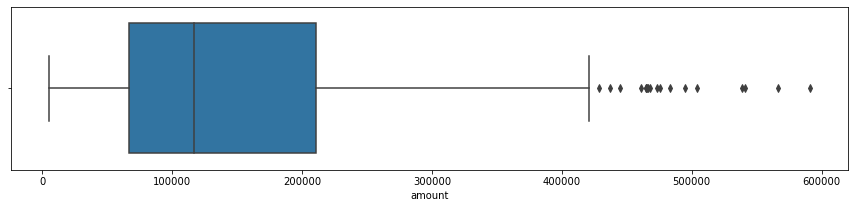

Feature amount : Mean = 151410.176, Median = 116928.0 and Inter-Quartile-Range (IQR) = 143922.0
There are 18 outliers (2.639 % of the data points) in amount feature and the values are [482940, 566640, 428784, 460980, 504000, 538500, 464520, 466608, 475680, 468060, 473280, 590820, 444864, 465072, 437460, 495180, 541200, 465504]
*****************************************************************************************************************************
******************************
Boxplot of A4 column : 
******************************


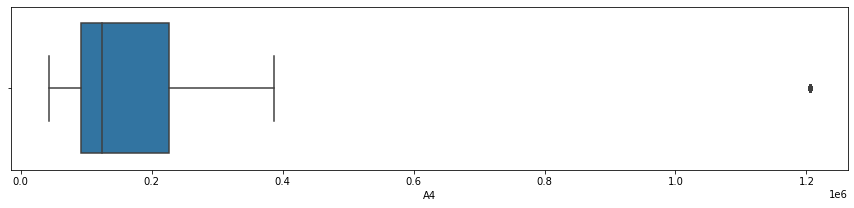

Feature A4 : Mean = 272052.236, Median = 124605.0 and Inter-Quartile-Range (IQR) = 134038.0
There are 84 outliers (12.317 % of the data points) in A4 feature and the values are [1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953]
******************************************************************

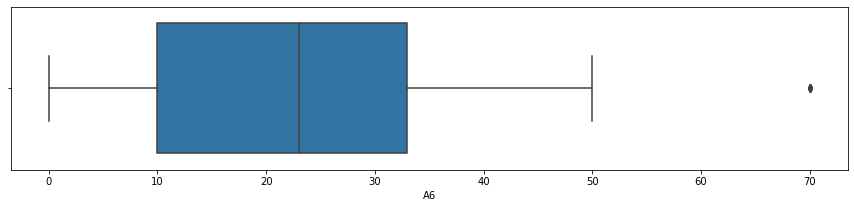

Feature A6 : Mean = 21.557, Median = 23.0 and Inter-Quartile-Range (IQR) = 23.0
There are 10 outliers (1.466 % of the data points) in A6 feature and the values are [70, 70, 70, 70, 70, 70, 70, 70, 70, 70]
*****************************************************************************************************************************
******************************
Boxplot of A7 column : 
******************************


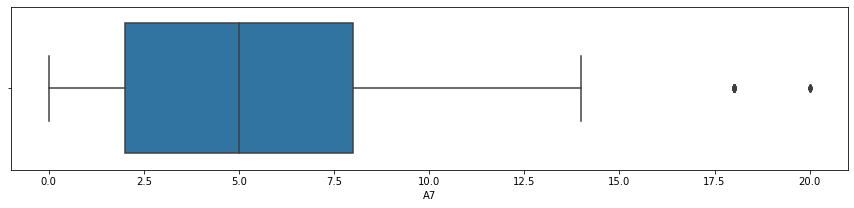

Feature A7 : Mean = 5.648, Median = 5.0 and Inter-Quartile-Range (IQR) = 6.0
There are 32 outliers (4.692 % of the data points) in A7 feature and the values are [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 20, 20, 20, 20, 20, 20, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
*****************************************************************************************************************************
******************************
Boxplot of A8 column : 
******************************


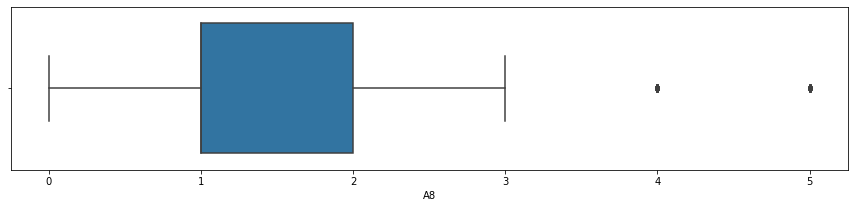

Feature A8 : Mean = 1.713, Median = 1.0 and Inter-Quartile-Range (IQR) = 1.0
There are 53 outliers (7.771 % of the data points) in A8 feature and the values are [4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
*****************************************************************************************************************************
******************************
Boxplot of A11 column : 
******************************


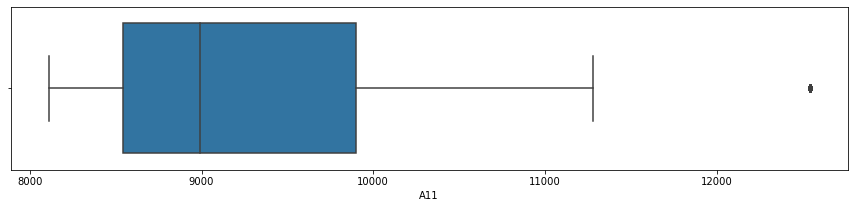

Feature A11 : Mean = 9502.987, Median = 8991.0 and Inter-Quartile-Range (IQR) = 1353.0
There are 84 outliers (12.317 % of the data points) in A11 feature and the values are [12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541, 12541]
*****************************************************************************************************************************
******************************
Boxplot of A13 column : 
******************************


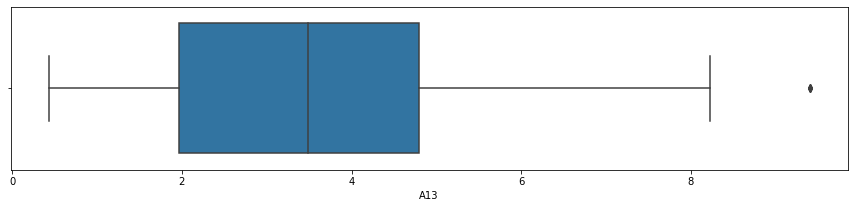

Feature A13 : Mean = 3.528, Median = 3.49 and Inter-Quartile-Range (IQR) = 2.83
There are 5 outliers (0.733 % of the data points) in A13 feature and the values are [9.4, 9.4, 9.4, 9.4, 9.4]
*****************************************************************************************************************************
******************************
Boxplot of A16 column : 
******************************


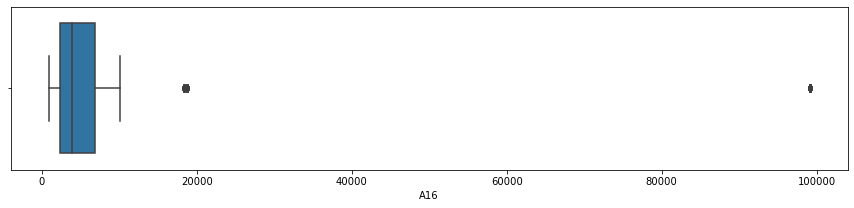

Feature A16 : Mean = 16390.818, Median = 3868.0 and Inter-Quartile-Range (IQR) = 4567.0
There are 128 outliers (18.768 % of the data points) in A16 feature and the values are [99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 99107, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18696, 18347, 18347, 18347, 18347, 18347, 18347, 18347, 18347, 18347, 18347

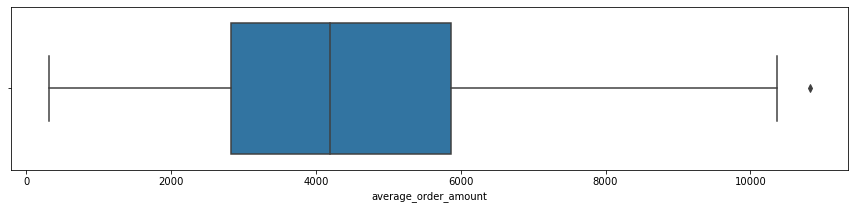

Feature average_order_amount : Mean = 4486.951, Median = 4193.617 and Inter-Quartile-Range (IQR) = 3039.533
There are 1 outliers (0.147 % of the data points) in average_order_amount feature and the values are [10817.0]
*****************************************************************************************************************************


,Column Name,Mean,Median,Lower Quartile,Upper Quartile,IQR,No of Outliers Present,Percentage of Outliers,Values of Outliers
0,client_id,7120.573,6941.0,3582.25,10711.0,7128.75,0,0.0 %,[]
1,disp_id,7002.702,6941.0,3582.25,10403.0,6820.75,0,0.0 %,[]
2,account_id,5824.163,5738.5,2967.0,8686.0,5719.0,0,0.0 %,[]
3,district_id,37.49,39.0,13.0,60.0,47.0,0,0.0 %,[]
4,loan_id,6172.466,6176.5,5577.5,6752.5,1175.0,0,0.0 %,[]
5,amount,151410.176,116928.0,66732.0,210654.0,143922.0,18,2.639 %,"[428784, 437460, 444864, 460980, 464520, 465072, 465504, 466608, 468060, 473280, 475680, 482940, 495180, 504000, 538500, 541200, 566640, 590820]"
6,duration,36.493,36.0,24.0,48.0,24.0,0,0.0 %,[]
7,payments,4190.664,3934.0,2477.0,5813.5,3336.5,0,0.0 %,[]
8,A4,272052.236,124605.0,92084.0,226122.0,134038.0,84,12.317 %,"[1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953, 1204953]"
9,A5,39.673,35.0,5.0,65.0,60.0,0,0.0 %,[]


In [60]:
showOutliers(main_df)

In [61]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   client_id              682 non-null    int64         
 1   disp_id                682 non-null    int64         
 2   account_id             682 non-null    int64         
 3   district_id            682 non-null    int64         
 4   loan_id                682 non-null    int64         
 5   date                   682 non-null    datetime64[ns]
 6   amount                 682 non-null    int64         
 7   duration               682 non-null    int64         
 8   payments               682 non-null    float64       
 9   status                 682 non-null    object        
 10  frequency              682 non-null    object        
 11  date_account           682 non-null    datetime64[ns]
 12  A2                     682 non-null    object        
 13  A3   

In [62]:
main_df.head().T

,0,1,2,3,4
client_id,13539,11126,2,9173,3001
disp_id,13231,10818,2,8865,3001
account_id,11013,9034,2,7401,2486
district_id,1,1,1,1,1
loan_id,7240,6820,4959,6499,5479
date,1993-09-06 00:00:00,1993-12-16 00:00:00,1994-01-05 00:00:00,1994-01-05 00:00:00,1994-01-10 00:00:00
amount,274740,38148,80952,80952,24516
duration,60,12,24,24,12
payments,4579.0,3179.0,3373.0,3373.0,2043.0
status,A,A,A,A,A


In [63]:
#Checking unique values in each column/feature
def column_unique_values(pd_data):
    '''
    Use to find out unique values available in each column of the dataset
    
    Parameters
    ----------
    pd_data : Pandas dataframe to be checked on for unique values
    
    Returns
    ----------
    Unique values avilable on each column in the pandas dataframe passed
    '''
    df = pd.DataFrame(columns = ['Column Name', 'Number of Rows', 'Number of Unique Values', 'Unique Values'])
    for col in pd_data.columns:
        df = df.append({'Column Name' : col, 'Number of Rows': pd_data.shape[0], 'Number of Unique Values':pd_data[col].nunique(), 'Unique Values':pd_data[col].unique()}, ignore_index=True)
    return df

In [64]:
# setting column width to zero to get maximum column width
pd.set_option("display.max_colwidth",None)

# calling user defined function to find out unique values available on the dataset except 'descripton' column
unique_col_values = column_unique_values(main_df)
unique_col_values

,Column Name,Number of Rows,Number of Unique Values,Unique Values
0,client_id,682,682,"[13539, 11126, 2, 9173, 3001, 13657, 1944, 12464, 9945, 10555, 9702, 11409, 512, 13412, 11574, 6178, 7299, 7241, 8610, 9933, 12859, 3576, 4520, 7390, 11866, 4433, 13548, 9418, 4527, 11662, 12181, 12416, 13955, 6987, 10963, 10282, 6299, 2746, 6033, 2592, 13231, 2550, 3907, 11114, 7765, 11709, 2720, 8200, 9505, 11545, 6039, 3471, 8030, 7772, 10813, 12382, 861, 7959, 4417, 13134, 13694, 2316, 13803, 8661, 12328, 4768, 5563, 10997, 2267, 3072, 12802, 11768, 11874, 10828, 13098, 3163, 7324, 8568, 4993, 2277, 11130, 4656, 6892, 3984, 5701, 10479, 9582, 3284, 2759, 13090, 7678, 5565, 4474, 4024, 3546, 8356, 10459, 9236, 1157, 5606, ...]"
1,disp_id,682,682,"[13231, 10818, 2, 8865, 3001, 13349, 1944, 12156, 9637, 10247, 9394, 11101, 512, 13104, 11266, 6178, 7299, 7241, 8610, 9625, 12551, 3576, 4520, 7390, 11558, 4433, 13240, 9110, 4527, 11354, 11873, 12108, 13647, 6987, 10655, 9974, 6299, 2746, 6033, 2592, 12923, 2550, 3907, 10806, 7765, 11401, 2720, 8200, 9197, 11237, 6039, 3471, 8030, 7772, 10505, 12074, 861, 7959, 4417, 12826, 13386, 2316, 13495, 8661, 12020, 4768, 5563, 10689, 2267, 3072, 12494, 11460, 11566, 10520, 12790, 3163, 7324, 8568, 4993, 2277, 10822, 4656, 6892, 3984, 5701, 10171, 9274, 3284, 2759, 12782, 7678, 5565, 4474, 4024, 3546, 8356, 10151, 8928, 1157, 5606, ...]"
2,account_id,682,682,"[11013, 9034, 2, 7401, 2486, 11111, 1603, 10131, 8051, 8558, 7844, 9265, 426, 10911, 9403, 5120, 6040, 5991, 7133, 8041, 10451, 2962, 3747, 6118, 9640, 3678, 11021, 7607, 3752, 9472, 9897, 10093, 11349, 5774, 8899, 8327, 5213, 2268, 4994, 2143, 10762, 2106, 3230, 9024, 6434, 9510, 2246, 6792, 7674, 9377, 4999, 2872, 6649, 6440, 8772, 10068, 718, 6592, 3664, 10679, 11141, 1906, 11231, 7176, 10022, 3953, 4616, 8926, 1869, 2545, 10404, 9560, 9646, 8784, 10652, 2622, 6061, 7099, 4144, 1876, 9037, 3862, 5698, 3293, 4727, 8492, 7745, 2720, 2279, 10645, 6358, 4618, 3711, 3329, 2936, 6922, 8475, 7454, 960, 4650, ...]"
3,district_id,682,77,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]"
4,loan_id,682,682,"[7240, 6820, 4959, 6499, 5479, 7259, 5285, 7066, 6647, 6736, 6596, 6888, 5060, 7220, 6919, 6038, 6229, 6223, 6460, 6645, 7142, 5576, 5739, 6244, 6960, 5724, 7241, 6546, 5740, 6929, 7008, 7057, 7304, 6185, 6785, 6698, 6063, 5429, 6012, 5385, 7194, 5375, 5635, 6817, 6309, 6940, 5419, 6377, 6562, 6913, 6014, 5556, 6346, 6310, 6763, 7051, 5117, 6338, 5719, 7181, 7264, 5343, 7277, 6468, 7037, 5782, 5930, 6791, 5332, 5491, 7129, 6948, 6962, 6766, 7172, 5501, 6234, 6450, 5823, 5334, 6821, 5760, 6168, 5644, 5959, 6726, 6574, 5525, 5435, 7168, 6296, 5931, 5731, 5651, 5569, 6402, 6721, 6512, 5151, 5938, ...]"
5,date,682,559,"[1993-09-06T00:00:00.000000000, 1993-12-16T00:00:00.000000000, 1994-01-05T00:00:00.000000000, 1994-01-10T00:00:00.000000000, 1994-01-31T00:00:00.000000000, 1994-02-06T00:00:00.000000000, 1994-05-02T00:00:00.000000000, 1994-06-01T00:00:00.000000000, 1994-06-14T00:00:00.000000000, 1994-06-25T00:00:00.000000000, 1994-07-11T00:00:00.000000000, 1994-07-19T00:00:00.000000000, 1994-07-28T00:00:00.000000000, 1994-08-05T00:00:00.000000000, 1994-08-10T00:00:00.000000000, 1994-10-02T00:00:00.000000000, 1994-11-03T00:00:00.000000000, 1994-11-06T00:00:00.000000000, 1994-12-19T00:00:00.000000000, 1994-12-21T00:00:00.000000000, 1995-01-02T00:00:00.000000000, 1995-01-08T00:00:00.000000000, 1995-01-11T00:00:00.000000000, 1995-02-05T00:00:00.000000000, 1995-03-04T00:00:00.000000000, 1995-03-27T00:00:00.000000000, 1995-04-02T00:00:00.000000000, 1995-05-08T00:00:00.000000000, 1995-09-22T00:00:00.000000000, 1995-10-20T00:00:00.000000000, 1995-10-29T00:00:00.000000000, 1995-11-28T00:00:00.000000000, 1995-12-25T00:00:00

In [65]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   client_id              682 non-null    int64         
 1   disp_id                682 non-null    int64         
 2   account_id             682 non-null    int64         
 3   district_id            682 non-null    int64         
 4   loan_id                682 non-null    int64         
 5   date                   682 non-null    datetime64[ns]
 6   amount                 682 non-null    int64         
 7   duration               682 non-null    int64         
 8   payments               682 non-null    float64       
 9   status                 682 non-null    object        
 10  frequency              682 non-null    object        
 11  date_account           682 non-null    datetime64[ns]
 12  A2                     682 non-null    object        
 13  A3   

In [66]:
main_df['acct_to_loan_duration'] = main_df['date'] - main_df ['date_account']
main_df['acct_to_loan_duration'] = main_df['acct_to_loan_duration'].dt.days
main_df['age'] = pd.to_datetime('1998-01-01', format='%Y-%m-%d') - pd.to_datetime(main_df['date_of_birth'], format='%Y-%m-%d')
main_df['age'] = main_df['age'].dt.days/365
main_df.drop(columns=['date','date_account','date_of_birth','issued'],inplace=True)
# main_df = main_df.convert_dtypes()

In [67]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   client_id              682 non-null    int64  
 1   disp_id                682 non-null    int64  
 2   account_id             682 non-null    int64  
 3   district_id            682 non-null    int64  
 4   loan_id                682 non-null    int64  
 5   amount                 682 non-null    int64  
 6   duration               682 non-null    int64  
 7   payments               682 non-null    float64
 8   status                 682 non-null    object 
 9   frequency              682 non-null    object 
 10  A2                     682 non-null    object 
 11  A3                     682 non-null    object 
 12  A4                     682 non-null    int64  
 13  A5                     682 non-null    int64  
 14  A6                     682 non-null    int64  
 15  A7    

In [68]:
main_df['card_id'] = main_df['card_id'].fillna(0)
main_df['type'] = main_df['type'].fillna("NA")
main_df['A12'].replace("?", "0", inplace=True)
main_df['A12'] = main_df['A12'].astype(float)
main_df['A15'].replace("?", "0", inplace=True)
main_df['A15'] = main_df['A15'].astype(int)

In [69]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   client_id              682 non-null    int64  
 1   disp_id                682 non-null    int64  
 2   account_id             682 non-null    int64  
 3   district_id            682 non-null    int64  
 4   loan_id                682 non-null    int64  
 5   amount                 682 non-null    int64  
 6   duration               682 non-null    int64  
 7   payments               682 non-null    float64
 8   status                 682 non-null    object 
 9   frequency              682 non-null    object 
 10  A2                     682 non-null    object 
 11  A3                     682 non-null    object 
 12  A4                     682 non-null    int64  
 13  A5                     682 non-null    int64  
 14  A6                     682 non-null    int64  
 15  A7    

In [70]:
# This function returns the encoded columns
def get_one_hot_encoded_features(pdData,cols):
    '''
    One hot encoding using get_dummies function to encode Non Ordinal columns of pandas dataframe
    
    Parameters
    ----------
    pdData : Pandas dataframe to be used
    cols   : list of columns to be encoded using one hot encoding
    
    Returns
    ---------
    Pandas dataframe containing one hot encoded columns
    '''
    encd_data = pd.DataFrame()
    for col in cols:
        encd_data = pd.concat([encd_data,pd.get_dummies(pdData[col],drop_first=True,columns=[col])],axis=1)
    return encd_data

In [71]:
# list of Non-Ordinal columns to be encoded to one hot encoding
col_list = ['frequency', 'type', 'gender']
#calling user defined one hot encoding function
one_hot_encoded_features = get_one_hot_encoded_features(main_df,col_list)

In [72]:
main_df.drop(columns=['frequency', 'type', 'gender'],inplace=True)

In [73]:
def get_label_encoded_features(pdData,cols):
    '''
    Label encoding to encode columns of pandas dataframe
    
    Parameters
    ----------
    pdData : Pandas dataframe to be used
    cols   : Dictionary of columns and respective values to be label encode
    
    Returns
    ---------
    Pandas dataframe containing label encoded columns
    '''
    encd_df = pd.DataFrame()
    for col,val in cols.items():
        encd_df = pd.concat([encd_df,pdData[col].replace(val)],axis=1)
    return encd_df

In [74]:
# defining column dictionary to be encoded with respective values
label_encod_dict = {
                    'A2':{'Hl.m. Praha':0, 'Benesov':1 , 'Beroun':2, 'Kladno':3, 'Kolin':4, 'Kutna Hora':5, 'Melnik':6, 'Mlada Boleslav':7, 'Nymburk':8,
                          'Praha - vychod':9, 'Praha - zapad':10, 'Pribram':11, 'Rakovnik':12, 'Ceske Budejovice':13, 'Cesky Krumlov':14, 'Jindrichuv Hradec':15,
                          'Pelhrimov':16, 'Pisek':17, 'Prachatice':18, 'Strakonice':19, 'Tabor':20, 'Domazlice':21, 'Cheb':22, 'Karlovy Vary':23, 'Klatovy':24, 'Plzen - mesto':25,
                          'Plzen - jih':26, 'Plzen - sever':27, 'Rokycany':28, 'Sokolov':29, 'Tachov':30, 'Ceska Lipa':31, 'Decin':32, 'Chomutov':33, 'Jablonec n. Nisou':34,
                          'Liberec':35, 'Litomerice':36, 'Louny':37, 'Most':38, 'Teplice':39, 'Usti nad Labem':40, 'Havlickuv Brod':41, 'Hradec Kralove':42, 'Chrudim':43, 'Jicin':44,
                          'Nachod':45, 'Pardubice':46, 'Rychnov nad Kneznou':47, 'Semily':48, 'Svitavy':49, 'Trutnov':50, 'Usti nad Orlici':51, 'Blansko':52, 'Brno - mesto':53, 
                          'Brno - venkov':54, 'Breclav':55, 'Hodonin':56, 'Jihlava':57, 'Kromeriz':58, 'Prostejov':59, 'Trebic':60, 'Uherske Hradiste':61, 'Vyskov':62, 'Zlin':63, 'Znojmo':64,
                          'Zdar nad Sazavou':65, 'Bruntal':66, 'Frydek - Mistek':67, 'Jesenik':68, 'Karvina':69, 'Novy Jicin':70, 'Olomouc':71, 'Opava':72, 'Ostrava - mesto':73,
                          'Prerov':74, 'Sumperk':75, 'Vsetin':76},
                    'A3':{'Prague':0, 'central Bohemia':1, 'south Bohemia':2, 'west Bohemia':3, 'north Bohemia':4, 'east Bohemia':5, 'south Moravia':6, 'north Moravia':7},
                    'status': {'A':0,'B':1,'C':0,'D':1}
                   }

In [75]:
# calling user defined label encoder to label encode
label_encoded_features = get_label_encoded_features(main_df,label_encod_dict)

In [76]:
main_df.drop(columns=['A2', 'A3', 'status'],inplace=True)

In [77]:
# concatinating 'month','day','description' columns from main dataset with one hot encoded columns and label encoded columns to arrive final dataset for Milestone 2
main_df = pd.concat([main_df,one_hot_encoded_features,label_encoded_features],axis=1)

In [78]:
main_df.head().T

,0,1,2,3,4
client_id,1.353900e+04,1.112600e+04,2.000000e+00,9.173000e+03,3.001000e+03
disp_id,1.323100e+04,1.081800e+04,2.000000e+00,8.865000e+03,3.001000e+03
account_id,1.101300e+04,9.034000e+03,2.000000e+00,7.401000e+03,2.486000e+03
district_id,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
loan_id,7.240000e+03,6.820000e+03,4.959000e+03,6.499000e+03,5.479000e+03
amount,2.747400e+05,3.814800e+04,8.095200e+04,8.095200e+04,2.451600e+04
duration,6.000000e+01,1.200000e+01,2.400000e+01,2.400000e+01,1.200000e+01
payments,4.579000e+03,3.179000e+03,3.373000e+03,3.373000e+03,2.043000e+03
A4,1.204953e+06,1.204953e+06,1.204953e+06,1.204953e+06,1.204953e+06
A5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [79]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 682 entries, 0 to 681
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   client_id              682 non-null    int64  
 1   disp_id                682 non-null    int64  
 2   account_id             682 non-null    int64  
 3   district_id            682 non-null    int64  
 4   loan_id                682 non-null    int64  
 5   amount                 682 non-null    int64  
 6   duration               682 non-null    int64  
 7   payments               682 non-null    float64
 8   A4                     682 non-null    int64  
 9   A5                     682 non-null    int64  
 10  A6                     682 non-null    int64  
 11  A7                     682 non-null    int64  
 12  A8                     682 non-null    int64  
 13  A9                     682 non-null    int64  
 14  A10                    682 non-null    float64
 15  A11        

Text(0.5, 1.0, 'Correlation between attributes')

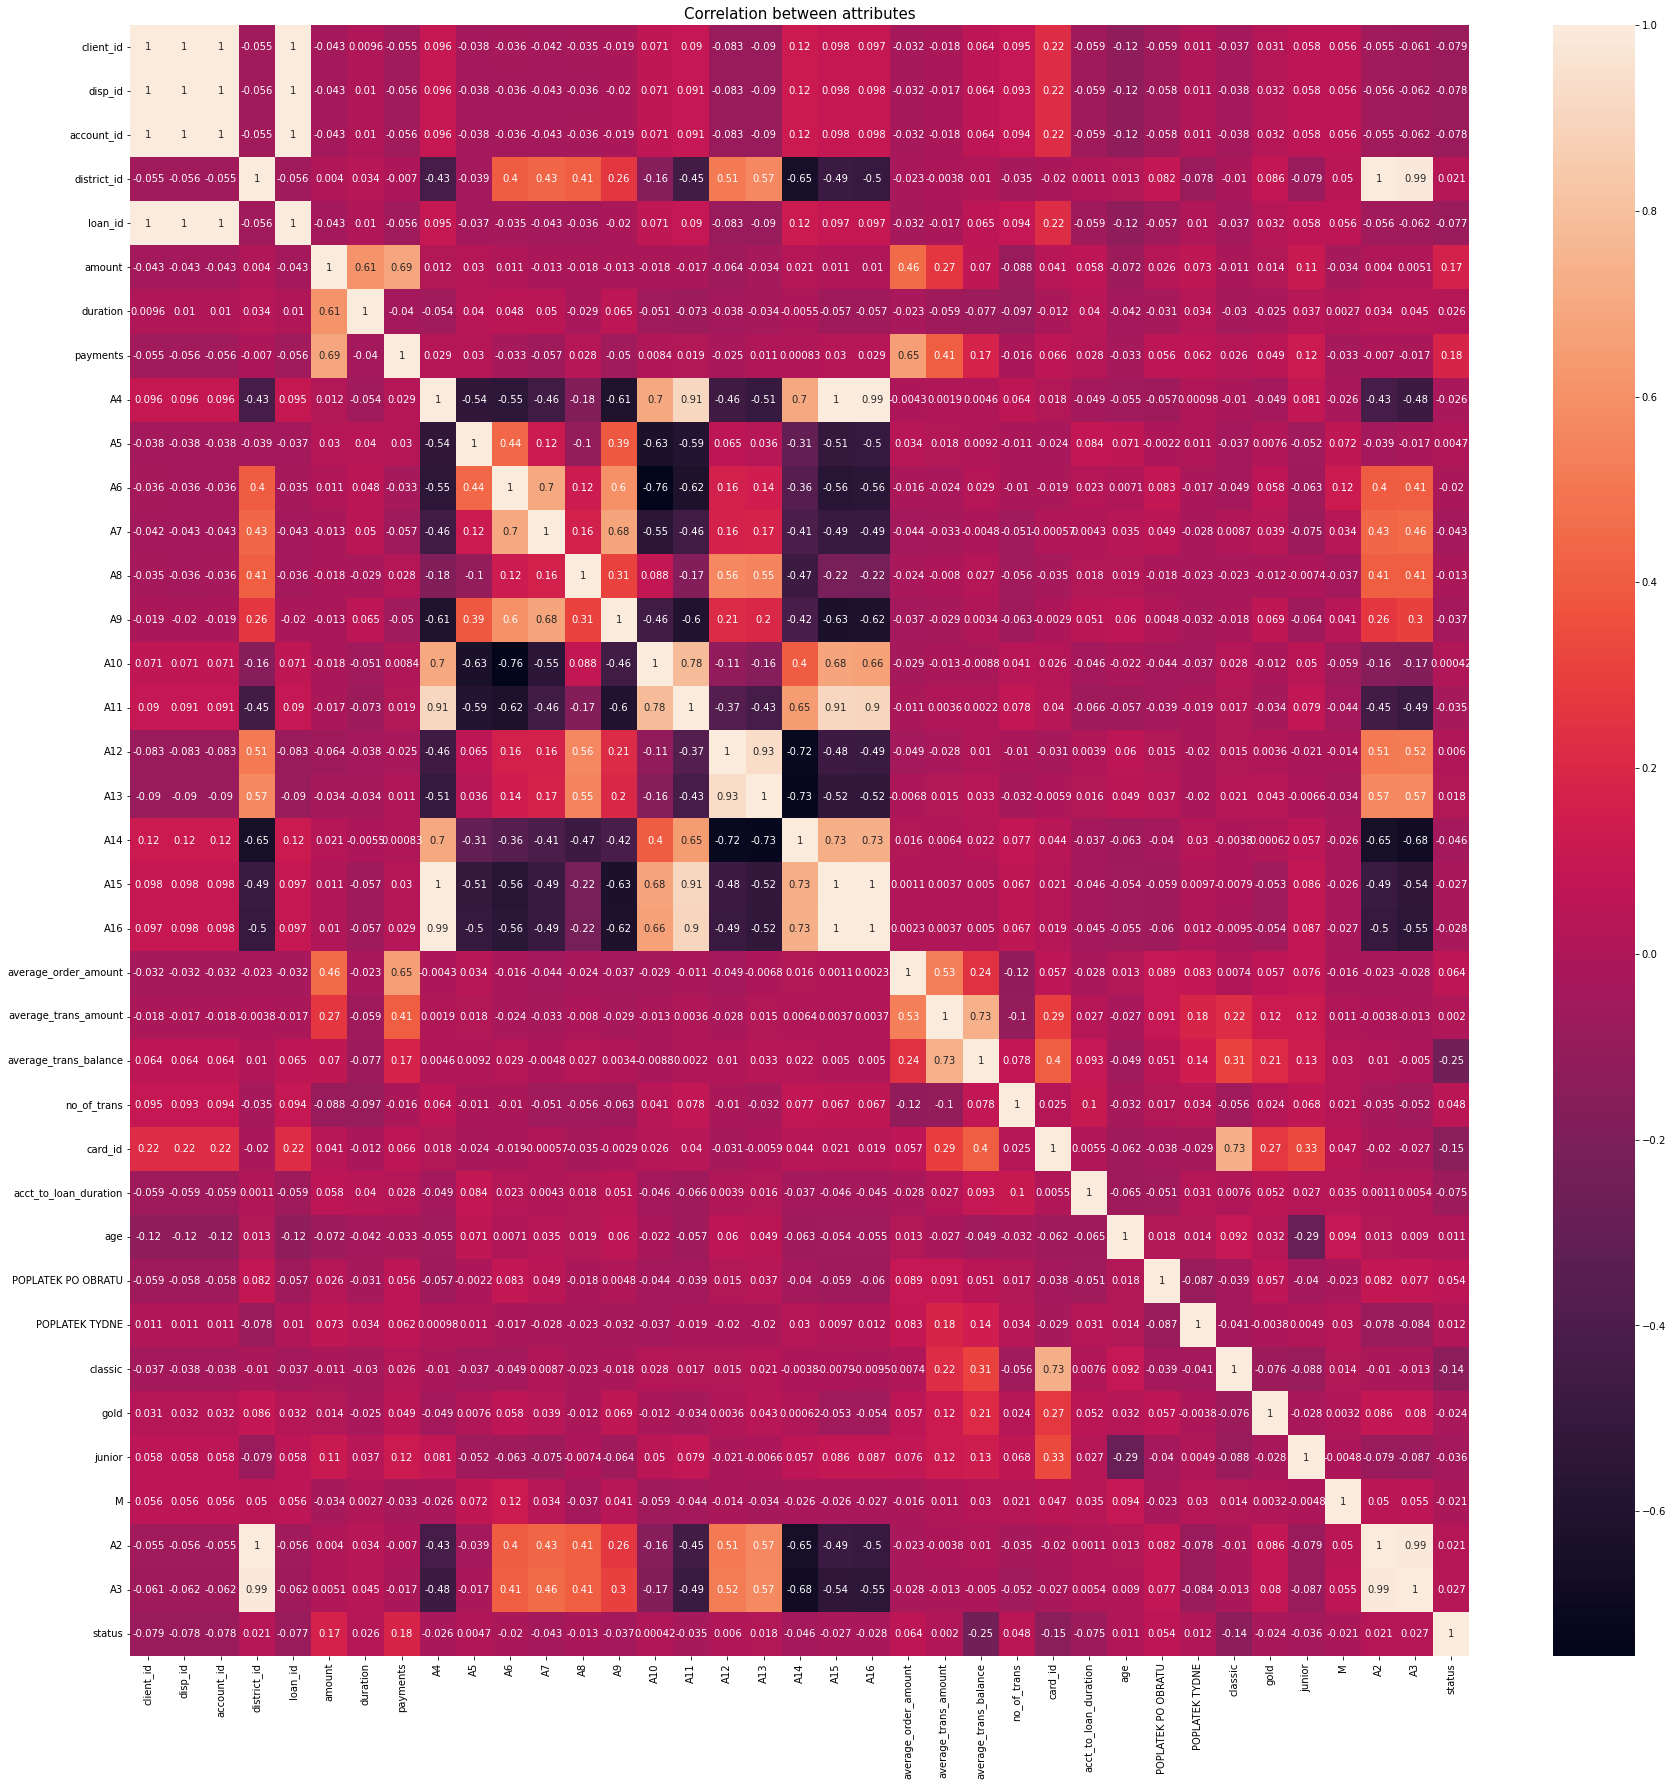

In [80]:
fig = plt.subplots(figsize=(30,30))
sns.heatmap(main_df.corr(), annot=True)
plt.title('Correlation between attributes', fontsize=15)

In [81]:
def showCorr(pdData,limit=0.80):
    colNames = []
    posIndex = []
    posCorr = []
    posCorrCnt = []
    negIndex = []
    negCorr = []
    negCorrCnt = []
    cols = pdData.columns
    corrs = pdData.corr()
    
    # to eliminate attibutes with self correlated values in the output
    np.fill_diagonal(corrs.values, 0)
    
    length = len(cols)
    for col in cols:
        posCorrVal = round(corrs[round(corrs[col],2) >= limit][col],2)
        negCorrVal = round(corrs[round(corrs[col],2) <= limit*-1][col],2)
        
        if((len(posCorrVal) > 0) | (len(negCorrVal) > 0)):
            colNames.append(col)

            posIndex.append(posCorrVal.index.tolist())
            posCorr.append(posCorrVal.tolist())
            posCorrCnt.append(len(posCorrVal))

            negIndex.append(negCorrVal.index.tolist())
            negCorr.append(negCorrVal.tolist())
            negCorrCnt.append(len(negCorrVal))
    data = [colNames, posCorrCnt, posIndex, posCorr, negCorrCnt, negIndex, negCorr]
    pd.set_option("display.max_colwidth", 0)
    corrPd = pd.DataFrame(data,index=['Attribute Name', 'Number of Attributes with +ve Correlation',
                                      'Attributes with +ve Correlation', 'Positively Correlated Value',
                                      'Number of Attributes with -ve Correlation',
                                      'Attributes with -ve Correlation', 'Negatively Correlated Value'])
    return corrPd.T       

In [82]:
showCorr(main_df, 0.7)

,Attribute Name,Number of Attributes with +ve Correlation,Attributes with +ve Correlation,Positively Correlated Value,Number of Attributes with -ve Correlation,Attributes with -ve Correlation,Negatively Correlated Value
0,client_id,3,"[disp_id, account_id, loan_id]","[1.0, 1.0, 1.0]",0,[],[]
1,disp_id,3,"[client_id, account_id, loan_id]","[1.0, 1.0, 1.0]",0,[],[]
2,account_id,3,"[client_id, disp_id, loan_id]","[1.0, 1.0, 1.0]",0,[],[]
3,district_id,2,"[A2, A3]","[1.0, 0.99]",0,[],[]
4,loan_id,3,"[client_id, disp_id, account_id]","[1.0, 1.0, 1.0]",0,[],[]
5,A4,5,"[A10, A11, A14, A15, A16]","[0.7, 0.91, 0.7, 1.0, 0.99]",0,[],[]
6,A6,1,[A7],[0.7],1,[A10],[-0.76]
7,A7,1,[A6],[0.7],0,[],[]
8,A10,2,"[A4, A11]","[0.7, 0.78]",1,[A6],[-0.76]
9,A11,4,"[A4, A10, A15, A16]","[0.91, 0.78, 0.91, 0.9]",0,[],[]


In [83]:
# as nothing correlated with target column 'status', checking for minimum correlation 
showCorr(main_df, 0.1)

,Attribute Name,Number of Attributes with +ve Correlation,Attributes with +ve Correlation,Positively Correlated Value,Number of Attributes with -ve Correlation,Attributes with -ve Correlation,Negatively Correlated Value
0,client_id,8,"[disp_id, account_id, loan_id, A4, A14, A15, A16, card_id]","[1.0, 1.0, 1.0, 0.1, 0.12, 0.1, 0.1, 0.22]",1,[age],[-0.12]
1,disp_id,8,"[client_id, account_id, loan_id, A4, A14, A15, A16, card_id]","[1.0, 1.0, 1.0, 0.1, 0.12, 0.1, 0.1, 0.22]",1,[age],[-0.12]
2,account_id,8,"[client_id, disp_id, loan_id, A4, A14, A15, A16, card_id]","[1.0, 1.0, 1.0, 0.1, 0.12, 0.1, 0.1, 0.22]",1,[age],[-0.12]
3,district_id,8,"[A6, A7, A8, A9, A12, A13, A2, A3]","[0.4, 0.43, 0.41, 0.26, 0.51, 0.57, 1.0, 0.99]",6,"[A4, A10, A11, A14, A15, A16]","[-0.43, -0.16, -0.45, -0.65, -0.49, -0.5]"
4,loan_id,8,"[client_id, disp_id, account_id, A4, A14, A15, A16, card_id]","[1.0, 1.0, 1.0, 0.1, 0.12, 0.1, 0.1, 0.22]",1,[age],[-0.12]
5,amount,6,"[duration, payments, average_order_amount, average_trans_amount, junior, status]","[0.61, 0.69, 0.46, 0.27, 0.11, 0.17]",0,[],[]
6,duration,1,[amount],[0.61],1,[no_of_trans],[-0.1]
7,payments,6,"[amount, average_order_amount, average_trans_amount, average_trans_balance, junior, status]","[0.69, 0.65, 0.41, 0.17, 0.12, 0.18]",0,[],[]
8,A4,9,"[client_id, disp_id, account_id, loan_id, A10, A11, A14, A15, A16]","[0.1, 0.1, 0.1, 0.1, 0.7, 0.91, 0.7, 1.0, 0.99]",10,"[district_id, A5, A6, A7, A8, A9, A12, A13, A2, A3]","[-0.43, -0.54, -0.55, -0.46, -0.18, -0.61, -0.46, -0.51, -0.43, -0.48]"
9,A5,3,"[A6, A7, A9]","[0.44, 0.12, 0.39]",7,"[A4, A8, A10, A11, A14, A15, A16]","[-0.54, -0.1, -0.63, -0.59, -0.31, -0.51, -0.5]"


In [84]:
featured_df = main_df[['client_id','district_id','A4','A6','A12','amount','payments','average_trans_amount','card_id','classic','status']]

In [85]:
featured_df.head()

,client_id,district_id,A4,A6,A12,amount,payments,average_trans_amount,card_id,classic,status
0,13539,1,1204953,0,0.29,274740,4579.0,11166.871804,1223.0,0,0
1,11126,1,1204953,0,0.29,38148,3179.0,5386.022259,0.0,0,0
2,2,1,1204953,0,0.29,80952,3373.0,6593.052929,0.0,0,0
3,9173,1,1204953,0,0.29,80952,3373.0,6605.885774,0.0,0,0
4,3001,1,1204953,0,0.29,24516,2043.0,12940.828464,0.0,0,0


In [86]:
featured_df.to_csv('preprocessed_data.csv')